# Manuscript Figures

In [1]:
from os import path
import logging
import statistics

import pandas as pd
import numpy as np
from numpy import datetime64
import scipy

# third-party (pip install required)
from matplotlib import pylab
import matplotlib.pyplot as plt

from pymodulon.gene_util import *
from pymodulon.core import *
from pymodulon.plotting import *
from pymodulon.util import *
from pymodulon.io import *
from pymodulon.motif import *
from pymodulon.compare import *

import sklearn.metrics
from sklearn.preprocessing import StandardScaler

from pandas.core.base import DataError
import warnings
logging.captureWarnings(True)
warnings.filterwarnings('ignore')
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", category=pd.errors.PerformanceWarning)

pd.set_option('display.max_rows', 30)

## Define data paths

Enter the location of all your data paths here:

In [2]:
precise_ddb_data_path = path.join('..','precise_ddb_data') # Enter precise_ddb data path here
process_data_path = path.join('..','..','fermentation_data') # Enter precise_ddb data path here
precise_ddb_nr_json_path = path.join(precise_ddb_data_path,'precise_ddb_400_nr.json.gz')
precise_ddb_nr_imodulon_table_path = path.join(precise_ddb_data_path,'precise_ddb_400_imodulon_table_curated.csv')

## Load the data

In [3]:
precise_ddb_nr_imodulon_table = pd.read_csv(precise_ddb_nr_imodulon_table_path, index_col=0)
precise_ddb_nr_json_data = load_json_model(precise_ddb_nr_json_path)

In [4]:
#Load interpolated process data
precise_ddb_processdata = pd.read_csv(path.join(process_data_path,'process_summary_interpol.csv'),index_col=1,sep=',')

#Filter data
precise_ddb_processdata.drop(columns=['date','Unnamed: 0','reactor_id', 'study', 'sample_id', 'citrate [mmol/L]', 'pyruvate [mmol/L]', 'succinate [mmol/L]', 'formate [mmol/L]', 'lactate [mmol/L]', 'ethanol [mmol/L]'], inplace=True)

print(f'Before filtering for N/A:{precise_ddb_processdata.shape}')
precise_ddb_processdata.dropna(inplace=True)
print(f'After filtering for N/A:{precise_ddb_processdata.shape}')
precise_ddb_processdata.tail()

Before filtering for N/A:(548, 9)
After filtering for N/A:(502, 9)


,fed-batch time [h],CTR [mol/h],OTR [mol/h],OD [-],D-glucose consumed [cmol],growth rate [1/h],feed rate [L/h],D-glucose uptake rate [cmol/h],base volume [ml]
precise_ID,,,,,,,,,
DDB_0527,17.98,0.0201,0.0425,179.0,0.531,0.103,0.00333,0.00148,22.8
DDB_0528,19.99,0.0244,0.0517,189.0,0.651,0.113,0.00399,0.00210,26.7
DDB_0529,19.98,0.0251,0.0518,188.0,0.655,0.114,0.00402,0.00211,27.8
DDB_0530,23.96,0.0508,0.0525,254.0,0.982,0.113,0.00613,0.00210,37.1
DDB_0531,23.98,0.0500,0.0522,243.0,0.986,0.104,0.00608,0.00211,37.3


In [5]:
#Filter subset with associated high-quality log tpm data
process_samples = precise_ddb_processdata.index.tolist()
process_samples_X = precise_ddb_nr_json_data.X[precise_ddb_nr_json_data.X.columns.intersection(process_samples)]
process_samples_A = precise_ddb_nr_json_data.A[precise_ddb_nr_json_data.A.columns.intersection(process_samples)]
processdata = precise_ddb_processdata.loc[process_samples_X.columns]
process_samples_metadata = precise_ddb_nr_json_data.sample_table.loc[process_samples_X.columns]
print(process_samples_X.shape)
print(process_samples_A.shape)
print(precise_ddb_processdata.shape)
print(process_samples_metadata.shape)

(4211, 441)
(266, 441)
(502, 9)
(441, 37)


In [6]:
#Filter non-relevant data (e.g. Genome-reduced Strains)
excluded_conditions = ['GenRed','BL21','HMP3397','baeR', 'rpoS', 'SDT288', 'SDT405', 'slow_feed'] #

excluded_index = [] #'DDB_0413','DDB_0426'

for i in excluded_conditions:
    excluded_index.extend(process_samples_metadata[
                                    process_samples_metadata.condition.str.contains(f'{i}')
                                    ].index)

process_samples_X.drop(excluded_index, axis=1, inplace=True)
process_samples_A.drop(excluded_index, axis=1, inplace=True)
processdata.drop(excluded_index, axis=0, inplace=True)
process_samples_metadata.drop(excluded_index, axis=0, inplace=True)

print(process_samples_X.shape)
print(process_samples_A.shape)
print(precise_ddb_processdata.shape)
print(process_samples_metadata.shape)

(4211, 377)
(266, 377)
(502, 9)
(377, 37)


## Define samples groups, categories and treatments

In [7]:
list_single_genes = precise_ddb_nr_json_data.imodulon_table[precise_ddb_nr_json_data.imodulon_table['single_gene']=='True'].index.tolist()

In [8]:
#Introduce sample_groups, 'no_group' and 'no_category' will help to identify samples without group
process_samples_metadata['sample_group'] = 'no_group'
process_samples_metadata['category'] = 'no_category'
process_samples_metadata['treatment'] = 'no_treatment'

#List all sample groups and categories for later comparison
treatments = ['ZnFeLow', 'ZnFeHigh']
sample_groups = ['DDB', 'HMP3427', 'HMP3071', 'WT']
sample_groups_labels = sample_groups
categories = ['phase_0','phase_1','phase_2','phase_3']
categories_labels = ['Batch', 'Early fed-batch', 'Late fed-batch', 'Crash']

In [9]:
SDT551_batch_phase_0 = process_samples_metadata[
                        process_samples_metadata.condition.str.contains('[Batch]', regex=False)
                        ][
                        process_samples_metadata.condition.str.contains('SDT551')
                        ][
                        process_samples_metadata['Time in phase [h]'] < 0.01
                        ][
                        'condition'].unique()

process_samples_metadata.loc[process_samples_metadata['condition'].isin(SDT551_batch_phase_0), 'sample_group'] = 'SDT551'
process_samples_metadata.loc[process_samples_metadata['condition'].isin(SDT551_batch_phase_0), 'category'] = 'phase_0'

SDT551_fedbatch_phase_1 = process_samples_metadata[
                        process_samples_metadata.condition.str.contains('[Fed-batch]', regex=False)
                        ][
                        process_samples_metadata.condition.str.contains('SDT551')
                        ][
                        process_samples_metadata['Time in phase [h]'] >= 0.01
                        ][
                        process_samples_metadata['Time in phase [h]'] < 10
                        ][
                        'condition'].unique()

process_samples_metadata.loc[process_samples_metadata['condition'].isin(SDT551_fedbatch_phase_1), 'sample_group'] = 'SDT551'
process_samples_metadata.loc[process_samples_metadata['condition'].isin(SDT551_fedbatch_phase_1), 'category'] = 'phase_1'

SDT551_fedbatch_phase_2 = process_samples_metadata[
                        process_samples_metadata.condition.str.contains('[Fed-batch]', regex=False)
                        ][
                        process_samples_metadata.condition.str.contains('SDT551')
                        ][
                        process_samples_metadata['Time in phase [h]'] >= 10
                        ][
                        process_samples_metadata['Time in phase [h]'] < 18
                        ][
                        'condition'].unique()

process_samples_metadata.loc[process_samples_metadata['condition'].isin(SDT551_fedbatch_phase_2), 'sample_group'] = 'SDT551'
process_samples_metadata.loc[process_samples_metadata['condition'].isin(SDT551_fedbatch_phase_2), 'category'] = 'phase_2'

SDT551_fedbatch_phase_3 = process_samples_metadata[
                        process_samples_metadata.condition.str.contains('[Fed-batch]', regex=False)
                        ][
                        process_samples_metadata.condition.str.contains('SDT551')
                        ][
                        process_samples_metadata['Time in phase [h]'] >= 18
                        ][
                        'condition'].unique()

process_samples_metadata.loc[process_samples_metadata['condition'].isin(SDT551_fedbatch_phase_3), 'sample_group'] = 'SDT551'
process_samples_metadata.loc[process_samples_metadata['condition'].isin(SDT551_fedbatch_phase_3), 'category'] = 'phase_3'

In [10]:
HMP3071_batch_phase_0 = process_samples_metadata[
                        process_samples_metadata.condition.str.contains('[Batch]', regex=False)
                        ][
                        process_samples_metadata.condition.str.contains('HMP3071')
                        ][
                        process_samples_metadata['Time in phase [h]'] < 0.01
                        ][
                        'condition'].unique()

process_samples_metadata.loc[process_samples_metadata['condition'].isin(HMP3071_batch_phase_0), 'sample_group'] = 'HMP3071'
process_samples_metadata.loc[process_samples_metadata['condition'].isin(HMP3071_batch_phase_0), 'category'] = 'phase_0'

HMP3071_fedbatch_phase_1 = process_samples_metadata[
                        process_samples_metadata.condition.str.contains('[Fed-batch]', regex=False)
                        ][
                        process_samples_metadata.condition.str.contains('HMP3071')
                        ][
                        process_samples_metadata['Time in phase [h]'] >= 0.01
                        ][
                        process_samples_metadata['Time in phase [h]'] < 10
                        ][
                        'condition'].unique()

process_samples_metadata.loc[process_samples_metadata['condition'].isin(HMP3071_fedbatch_phase_1), 'sample_group'] = 'HMP3071'
process_samples_metadata.loc[process_samples_metadata['condition'].isin(HMP3071_fedbatch_phase_1), 'category'] = 'phase_1'

HMP3071_fedbatch_phase_2 = process_samples_metadata[
                        process_samples_metadata.condition.str.contains('[Fed-batch]', regex=False)
                        ][
                        process_samples_metadata.condition.str.contains('HMP3071')
                        ][
                        process_samples_metadata['Time in phase [h]'] >= 10
                        ][
                        process_samples_metadata['Time in phase [h]'] < 18
                        ][
                        'condition'].unique()

process_samples_metadata.loc[process_samples_metadata['condition'].isin(HMP3071_fedbatch_phase_2), 'sample_group'] = 'HMP3071'
process_samples_metadata.loc[process_samples_metadata['condition'].isin(HMP3071_fedbatch_phase_2), 'category'] = 'phase_2'

HMP3071_fedbatch_phase_3 = process_samples_metadata[
                        process_samples_metadata.condition.str.contains('[Fed-batch]', regex=False)
                        ][
                        process_samples_metadata.condition.str.contains('HMP3071')
                        ][
                        process_samples_metadata['Time in phase [h]'] >= 18
                        ][
                        'condition'].unique()

process_samples_metadata.loc[process_samples_metadata['condition'].isin(HMP3071_fedbatch_phase_3), 'sample_group'] = 'HMP3071'
process_samples_metadata.loc[process_samples_metadata['condition'].isin(HMP3071_fedbatch_phase_3), 'category'] = 'phase_3'

In [11]:
HMP3427_batch_phase_0 = process_samples_metadata[
                        process_samples_metadata.condition.str.contains('[Batch]', regex=False)
                        ][
                        process_samples_metadata.condition.str.contains('HMP3427')
                        ][
                        process_samples_metadata['Time in phase [h]'] < 0.01
                        ][
                        'condition'].unique()

process_samples_metadata.loc[process_samples_metadata['condition'].isin(HMP3427_batch_phase_0), 'sample_group'] = 'HMP3427'
process_samples_metadata.loc[process_samples_metadata['condition'].isin(HMP3427_batch_phase_0), 'category'] = 'phase_0'

HMP3427_fedbatch_phase_1 = process_samples_metadata[
                        process_samples_metadata.condition.str.contains('[Fed-batch]', regex=False)
                        ][
                        process_samples_metadata.condition.str.contains('HMP3427')
                        ][
                        process_samples_metadata['Time in phase [h]'] >= 0.01
                        ][
                        process_samples_metadata['Time in phase [h]'] < 10
                        ][
                        'condition'].unique()

process_samples_metadata.loc[process_samples_metadata['condition'].isin(HMP3427_fedbatch_phase_1), 'sample_group'] = 'HMP3427'
process_samples_metadata.loc[process_samples_metadata['condition'].isin(HMP3427_fedbatch_phase_1), 'category'] = 'phase_1'

HMP3427_fedbatch_phase_2 = process_samples_metadata[
                        process_samples_metadata.condition.str.contains('[Fed-batch]', regex=False)
                        ][
                        process_samples_metadata.condition.str.contains('HMP3427')
                        ][
                        process_samples_metadata['Time in phase [h]'] >= 10
                        ][
                        process_samples_metadata['Time in phase [h]'] < 18
                        ][
                        'condition'].unique()

process_samples_metadata.loc[process_samples_metadata['condition'].isin(HMP3427_fedbatch_phase_2), 'sample_group'] = 'HMP3427'
process_samples_metadata.loc[process_samples_metadata['condition'].isin(HMP3427_fedbatch_phase_2), 'category'] = 'phase_2'

HMP3427_fedbatch_phase_3 = process_samples_metadata[
                        process_samples_metadata.condition.str.contains('[Fed-batch]', regex=False)
                        ][
                        process_samples_metadata.condition.str.contains('HMP3427')
                        ][
                        process_samples_metadata['Time in phase [h]'] >= 18
                        ][
                        'condition'].unique()

process_samples_metadata.loc[process_samples_metadata['condition'].isin(HMP3427_fedbatch_phase_3), 'sample_group'] = 'HMP3427'
process_samples_metadata.loc[process_samples_metadata['condition'].isin(HMP3427_fedbatch_phase_3), 'category'] = 'phase_3'

In [12]:
WT_batch_phase_0 = process_samples_metadata[
                        process_samples_metadata.condition.str.contains('[Batch]', regex=False)
                        ][
                        process_samples_metadata.condition.str.contains('DDB7|DDB35')
                        ][
                        process_samples_metadata['Time in phase [h]'] < 0.01
                        ][
                        'condition'].unique()

process_samples_metadata.loc[process_samples_metadata['condition'].isin(WT_batch_phase_0), 'sample_group'] = 'WT'
process_samples_metadata.loc[process_samples_metadata['condition'].isin(WT_batch_phase_0), 'category'] = 'phase_0'

WT_fedbatch_phase_1 = process_samples_metadata[
                        process_samples_metadata.condition.str.contains('[Fed-batch]', regex=False)
                        ][
                        process_samples_metadata.condition.str.contains('DDB7|DDB35')
                        ][
                        process_samples_metadata['Time in phase [h]'] >= 0.01
                        ][
                        process_samples_metadata['Time in phase [h]'] < 10
                        ][
                        'condition'].unique()

process_samples_metadata.loc[process_samples_metadata['condition'].isin(WT_fedbatch_phase_1), 'sample_group'] = 'WT'
process_samples_metadata.loc[process_samples_metadata['condition'].isin(WT_fedbatch_phase_1), 'category'] = 'phase_1'

WT_fedbatch_phase_2 = process_samples_metadata[
                        process_samples_metadata.condition.str.contains('[Fed-batch]', regex=False)
                        ][
                        process_samples_metadata.condition.str.contains('DDB7|DDB35')
                        ][
                        process_samples_metadata['Time in phase [h]'] >= 10
                        ][
                        process_samples_metadata['Time in phase [h]'] < 18
                        ][
                        'condition'].unique()

process_samples_metadata.loc[process_samples_metadata['condition'].isin(WT_fedbatch_phase_2), 'sample_group'] = 'WT'
process_samples_metadata.loc[process_samples_metadata['condition'].isin(WT_fedbatch_phase_2), 'category'] = 'phase_2'

WT_fedbatch_phase_3 = process_samples_metadata[
                        process_samples_metadata.condition.str.contains('[Fed-batch]', regex=False)
                        ][
                        process_samples_metadata.condition.str.contains('DDB7|DDB35')
                        ][
                        process_samples_metadata['Time in phase [h]'] >= 18
                        ][
                        'condition'].unique()

process_samples_metadata.loc[process_samples_metadata['condition'].isin(WT_fedbatch_phase_3), 'sample_group'] = 'WT'
process_samples_metadata.loc[process_samples_metadata['condition'].isin(WT_fedbatch_phase_3), 'category'] = 'phase_3'

In [13]:
DDB_batch_phase_0 = process_samples_metadata[
                        process_samples_metadata.condition.str.contains('[Batch]', regex=False)
                        ][
                        ~process_samples_metadata.condition.str.contains('DDB7', regex=False)
                        ][
                        ~process_samples_metadata.condition.str.contains('HMP3427', regex=False)
                        ][
                        ~process_samples_metadata.condition.str.contains('HMP3071', regex=False)
                        ][
                        ~process_samples_metadata.condition.str.contains('SDT551', regex=False)
                        ][
                        ~process_samples_metadata.condition.str.contains('DDB35', regex=False)
                        ][
                        process_samples_metadata['Time in phase [h]'] < 0.01
                        ][
                        'condition'].unique()

process_samples_metadata.loc[process_samples_metadata['condition'].isin(DDB_batch_phase_0), 'sample_group'] = 'DDB'
process_samples_metadata.loc[process_samples_metadata['condition'].isin(DDB_batch_phase_0), 'category'] = 'phase_0'

DDB_fedbatch_phase_1 = process_samples_metadata[
                        process_samples_metadata.condition.str.contains('[Fed-batch]', regex=False)
                        ][
                        ~process_samples_metadata.condition.str.contains('DDB7', regex=False)
                        ][
                        ~process_samples_metadata.condition.str.contains('HMP3427', regex=False)
                        ][
                        ~process_samples_metadata.condition.str.contains('HMP3071', regex=False)
                        ][
                        ~process_samples_metadata.condition.str.contains('SDT551', regex=False)
                        ][
                        ~process_samples_metadata.condition.str.contains('DDB35', regex=False)
                        ][
                        process_samples_metadata['Time in phase [h]'] >= 0.01
                        ][
                        process_samples_metadata['Time in phase [h]'] < 10
                        ][
                        'condition'].unique()

process_samples_metadata.loc[process_samples_metadata['condition'].isin(DDB_fedbatch_phase_1), 'sample_group'] = 'DDB'
process_samples_metadata.loc[process_samples_metadata['condition'].isin(DDB_fedbatch_phase_1), 'category'] = 'phase_1'

DDB_fedbatch_phase_2 = process_samples_metadata[
                        process_samples_metadata.condition.str.contains('[Fed-batch]', regex=False)
                        ][
                        ~process_samples_metadata.condition.str.contains('DDB7', regex=False)
                        ][
                        ~process_samples_metadata.condition.str.contains('HMP3427', regex=False)
                        ][
                        ~process_samples_metadata.condition.str.contains('HMP3071', regex=False)
                        ][
                        ~process_samples_metadata.condition.str.contains('SDT551', regex=False)
                        ][
                        ~process_samples_metadata.condition.str.contains('DDB35', regex=False)
                        ][
                        process_samples_metadata['Time in phase [h]'] >= 10
                        ][
                        process_samples_metadata['Time in phase [h]'] < 18
                        ][
                        'condition'].unique()

process_samples_metadata.loc[process_samples_metadata['condition'].isin(DDB_fedbatch_phase_2), 'sample_group'] = 'DDB'
process_samples_metadata.loc[process_samples_metadata['condition'].isin(DDB_fedbatch_phase_2), 'category'] = 'phase_2'

DDB_fedbatch_phase_3 = process_samples_metadata[
                        process_samples_metadata.condition.str.contains('[Fed-batch]', regex=False)
                        ][
                        ~process_samples_metadata.condition.str.contains('DDB7', regex=False)
                        ][
                        ~process_samples_metadata.condition.str.contains('HMP3427', regex=False)
                        ][
                        ~process_samples_metadata.condition.str.contains('HMP3071', regex=False)
                        ][
                        ~process_samples_metadata.condition.str.contains('SDT551', regex=False)
                        ][
                        ~process_samples_metadata.condition.str.contains('DDB35', regex=False)
                        ][
                        process_samples_metadata['Time in phase [h]'] >= 18
                        ][
                        'condition'].unique()

process_samples_metadata.loc[process_samples_metadata['condition'].isin(DDB_fedbatch_phase_3), 'sample_group'] = 'DDB'
process_samples_metadata.loc[process_samples_metadata['condition'].isin(DDB_fedbatch_phase_3), 'category'] = 'phase_3'

In [14]:
FeZn_low = process_samples_metadata[
                        process_samples_metadata.condition.str.contains('ZnFeLow', regex=False)
                        ][
                        'condition'].unique()

process_samples_metadata.loc[process_samples_metadata['condition'].isin(FeZn_low), 'treatment'] = 'FeZn_low'

FeZn_high = process_samples_metadata[
                        process_samples_metadata.condition.str.contains('ZnFeHigh', regex=False)
                        ][
                        'condition'].unique()

process_samples_metadata.loc[process_samples_metadata['condition'].isin(FeZn_high), 'treatment'] = 'FeZn_high'

In [15]:
#Check whether all samples have a sample_group assigned
process_samples_metadata.loc[process_samples_metadata.sample_group.str.contains('no_group', regex=False)]

,sample_id,study,project,condition,rep_id,Biological Replicates,run_date,Strain Description,Strain,Base Media,...,Platform,passed_fastqc,passed_pct_reads_mapped,passed_reads_mapped_to_CDS,passed_global_correlation,full_name,passed_replicate_correlations,sample_group,category,treatment


In [16]:
index_filter = precise_ddb_nr_imodulon_table[precise_ddb_nr_imodulon_table['system_category'] != 'Single Gene'][precise_ddb_nr_imodulon_table['functional_category'] != 'Strain Difference'][precise_ddb_nr_imodulon_table['functional_category'] != 'Genome Reduction'].index
process_samples_A_filter = process_samples_A.loc[index_filter]
process_samples_A_filter

,DDB_0023,DDB_0024,DDB_0026,DDB_0029,DDB_0030,DDB_0031,DDB_0032,DDB_0053,DDB_0054,DDB_0055,...,DDB_0522,DDB_0523,DDB_0524,DDB_0525,DDB_0526,DDB_0527,DDB_0528,DDB_0529,DDB_0530,DDB_0531
iModulon,,,,,,,,,,,,,,,,,,,,,
BluR+MarA,-6.025378,-5.039965,-2.142528,1.075151,-0.607064,-3.605114,-2.882851,-2.688052,-1.865217,-2.004251,...,-1.723365,-1.904116,-2.345207,-1.481241,-0.940208,-1.666202,-1.446724,-1.067293,1.042782,1.094486
GadXW-2,-11.601380,-11.605233,-11.099011,-9.724835,-10.748606,-8.850694,-10.803780,6.910245,7.199694,7.029842,...,12.027222,12.153072,10.885538,10.929461,9.471799,9.285804,8.206004,8.376779,13.030343,11.985786
PaaX,-0.881685,-1.019470,5.981736,-1.621990,-1.781445,1.942655,2.005062,0.128279,-1.531470,-1.125393,...,1.381072,2.141019,2.138678,1.922287,1.753762,2.393938,1.939005,2.420290,0.808896,1.987123
Mannonate/Chitin,-1.177164,-1.182243,0.324454,-1.828629,-1.769286,-1.467428,-1.307532,-2.650853,-3.115445,-3.398863,...,-1.468746,-1.107245,-0.366052,-0.601078,-0.531149,-0.624376,-0.774887,-0.477050,-1.996294,-2.444112
Thr/Ser,-0.008370,0.326243,0.246964,1.084337,1.401442,0.431603,-0.633762,0.367634,-1.416141,-1.936178,...,0.287371,0.427943,0.543678,0.084924,0.363385,0.267681,-0.091785,0.011679,0.909831,0.982896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Periplasm Redox,-4.177024,-4.476084,-4.033597,-3.126204,-4.206205,-0.864315,-0.034000,-1.207017,-4.731605,-5.377190,...,-2.015407,-2.333218,-1.365562,-1.872919,-1.352318,-2.352326,-2.276104,-2.086885,0.463368,-0.040847
Iron Uptake-2,-8.102770,-8.006775,-6.196743,-9.338236,-9.316902,-16.387007,-16.813303,-9.539368,-9.811284,-9.142558,...,-9.277369,-9.503741,-8.987585,-9.201041,-8.743685,-8.763034,-8.495518,-8.584487,-10.026330,-9.634168
cyoB/ndh/nuoB KO,0.577041,0.431872,0.509519,2.456811,2.005217,2.050556,2.595674,-1.049622,-2.015483,-2.518462,...,-0.860406,-0.465612,-0.628239,-0.469350,-0.444469,-0.116312,-0.128078,-0.396485,0.449926,0.725165


In [17]:
# PCA with standard-scaled data (zero mean and unit variance)

data_matrix = process_samples_A_filter
_dimensions = 3

_pca = PCA(_dimensions)
_scaler = StandardScaler()

pca_list = []
for dimension in range(_dimensions):
    pca_list.append(f'PC{dimension+1}')

_scaler.fit(data_matrix)
data_matrix_scaled = _scaler.transform(data_matrix)

df_weights = pd.DataFrame(_pca.fit_transform(data_matrix_scaled.T),index=data_matrix.columns, columns=pca_list)
df_components = pd.DataFrame(_pca.components_.T, index=data_matrix.index, columns=pca_list)
df_loadings = pd.DataFrame(_pca.components_.T * np.sqrt(_pca.explained_variance_), index=data_matrix.index, columns=pca_list)

print(f'Explained Variance PC1: {_pca.explained_variance_ratio_[0]*100}')
print(f'Explained Variance PC2: {_pca.explained_variance_ratio_[1]*100}')
print(f'Explained Variance PC3: {_pca.explained_variance_ratio_[2]*100}')

# df_weights.to_csv(path.join(precise_ddb_data_path,'PCA', 'A_weights.csv') ,sep=',')
# df_components.to_csv(path.join(precise_ddb_data_path,'PCA','A_components.csv') ,sep=',')
# df_loadings.to_csv(path.join(precise_ddb_data_path,'PCA','A_loadings.csv') ,sep=',')

Explained Variance PC1: 36.92848702445272
Explained Variance PC2: 17.091855062172108
Explained Variance PC3: 9.238524890779837


In [18]:
# optional: filter samples from high resolution experiment
_excluded_index = process_samples_metadata[~process_samples_metadata.condition.str.contains('DDB_PD_107', regex=False)][~process_samples_metadata.condition.str.contains('DDB_PD_110', regex=False)][~process_samples_metadata.condition.str.contains('DDB_PD_111', regex=False)].index.tolist()

hr_process_samples_X = process_samples_X.drop(_excluded_index, axis=1)
hr_process_samples_A = process_samples_A.drop(_excluded_index, axis=1)
hr_precise_ddb_processdata = precise_ddb_processdata.drop(_excluded_index, axis=0)
hr_process_samples_metadata = process_samples_metadata.drop(_excluded_index, axis=0)

print(hr_process_samples_X.shape)
print(hr_process_samples_A.shape)
print(hr_precise_ddb_processdata.shape)
print(hr_process_samples_metadata.shape)

(4211, 128)
(266, 128)
(253, 9)
(128, 40)


Text(0, 0.5, 'PC2 (iModulon Activities)')

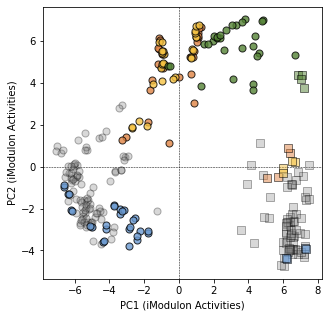

In [19]:
_variable_list = ['PC1', 'PC2']
_sample_groups = ['WT', 'HMP3071', 'SDT551', 'HMP3427']
_colors = ['#6a99d0', '#df8344', '#f5c242', '#548235']

_data_matrix = df_weights.copy()

_, ax = plt.subplots(figsize=(5, 5))

ax.axvline(0, linestyle='--', color='black', zorder=-1, linewidth=0.5)
ax.axhline(0, linestyle='--', color='black', zorder=-1, linewidth=0.5)

## DDB Background Scatter
_metadata = process_samples_metadata.copy()
_sample_list = process_samples_metadata[process_samples_metadata['sample_group']=='DDB'][_metadata['category'] == 'phase_0'].index.tolist()
ax.scatter(_data_matrix.loc[_sample_list,_variable_list[0]], _data_matrix.loc[_sample_list,_variable_list[1]], marker='s', c='#7F7F7F', s=50, alpha=0.3, linewidths=1, edgecolors="k")
_sample_list = process_samples_metadata[process_samples_metadata['sample_group']=='DDB'][_metadata['category'] != 'phase_0'].index.tolist()
ax.scatter(_data_matrix.loc[_sample_list,_variable_list[0]], _data_matrix.loc[_sample_list,_variable_list[1]], marker='o', c='#7F7F7F', s=50, alpha=0.3, linewidths=1, edgecolors="k")

_metadata = hr_process_samples_metadata.copy()
## Batch Scatter
for _i in range(len(_sample_groups)):
    _sample_list = _metadata[_metadata['sample_group'] == _sample_groups[_i]][_metadata['category'] == 'phase_0'].index.tolist()
    ax.scatter(_data_matrix.loc[_sample_list,_variable_list[0]], _data_matrix.loc[_sample_list,_variable_list[1]], marker='s', c=_colors[_i], s=50, alpha=0.5, linewidths=1, edgecolors="k")

## Fed Batch Scatter
for _i in range(len(_sample_groups)):
    _sample_list = _metadata[_metadata['sample_group'] == _sample_groups[_i]][_metadata['category'] != 'phase_0'].index.tolist()
    ax.scatter(_data_matrix.loc[_sample_list,_variable_list[0]], _data_matrix.loc[_sample_list,_variable_list[1]], marker='o', c=_colors[_i], s=50, alpha=0.8, linewidths=1, edgecolors="k")

ax.set_xlabel(f'{_variable_list[0]} (iModulon Activities)', fontsize=10)
ax.set_ylabel(f'{_variable_list[1]} (iModulon Activities)', fontsize=10)


## Compare production strains WT and SGKO strains

,difference,pvalue,qvalue,0,1
IS1,7.052528,0.000145,0.038458,-9.524605,-2.472077


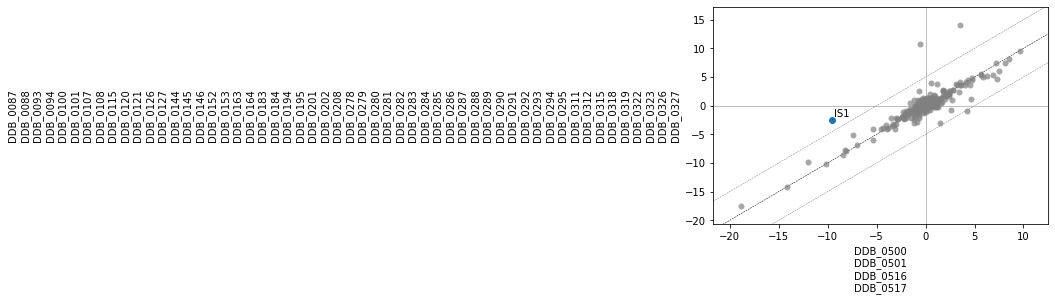

In [20]:
_metadata = hr_process_samples_metadata.copy()

_reference_sample_list = process_samples_metadata[process_samples_metadata.condition.str.contains('DDB35', regex=False)][process_samples_metadata.treatment.str.contains('FeZn_high|FeZn_low')][process_samples_metadata['Time in phase [h]'] <= 0]['condition'].index.unique()
_condition_sample_list = process_samples_metadata[process_samples_metadata.condition.str.contains('_del_', regex=False)][process_samples_metadata['Time in phase [h]'] <= 0]['condition'].index.unique()

ax, table = plot_dima(precise_ddb_nr_json_data,
          _reference_sample_list,
          _condition_sample_list,
          threshold=5.0,
          fdr=0.1,
          table=True,
          adjust=True,
          fit_line=False,
          line45_margin=5,
          label=True)
table

,difference,pvalue,qvalue,0,1
IS1,5.954163,0.00032,0.084992,-7.847651,-1.893488


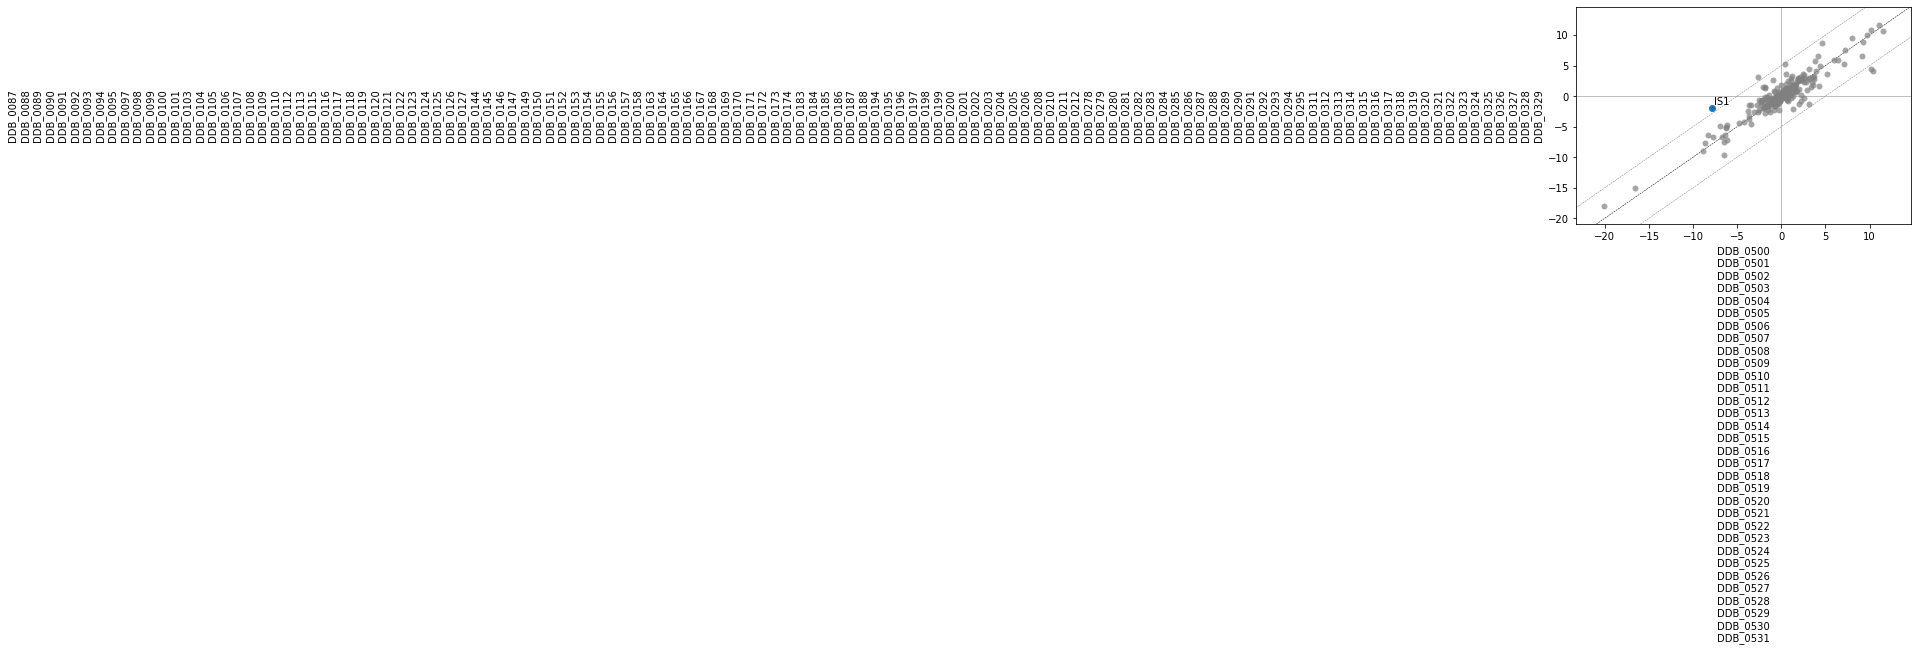

In [21]:
_metadata = hr_process_samples_metadata.copy()

_reference_sample_list = process_samples_metadata[process_samples_metadata.condition.str.contains('DDB35', regex=False)][process_samples_metadata.treatment.str.contains('FeZn_high|FeZn_low')][process_samples_metadata['Time in phase [h]'] >= 0]['condition'].index.unique()
_condition_sample_list = process_samples_metadata[process_samples_metadata.condition.str.contains('_del_', regex=False)][process_samples_metadata['Time in phase [h]'] >= 0]['condition'].index.unique()

ax, table = plot_dima(precise_ddb_nr_json_data,
          _reference_sample_list,
          _condition_sample_list,
          threshold=5.0,
          fdr=0.1,
          table=True,
          adjust=True,
          fit_line=False,
          line45_margin=5,
          label=True)
table

## Compare production strains HMP3071 and SDT551

,difference,pvalue,qvalue,0,1


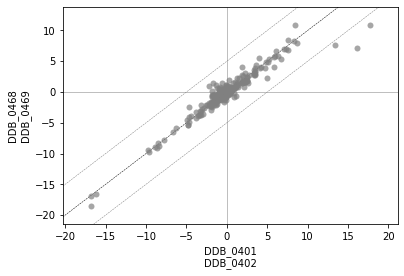

In [22]:
# HMP3071 and SDT551 / FeZnLow / Batch Phase
_metadata = hr_process_samples_metadata.copy()

_sample_groups = ['WT', 'HMP3071', 'SDT551', 'HMP3427']
_categories = ['phase_0','phase_1','phase_2','phase_3']
_treatments = ['FeZn_low', 'FeZn_high']

_reference_sample_list = _metadata[_metadata['category'] == _categories[0]][_metadata['treatment'] == _treatments[0]][_metadata['sample_group'] == _sample_groups[1]].index.tolist()
_condition_sample_list = _metadata[_metadata['category'] == _categories[0]][_metadata['treatment'] == _treatments[0]][_metadata['sample_group'] == _sample_groups[2]].index.tolist()

ax, table = plot_dima(precise_ddb_nr_json_data,
          _reference_sample_list,
          _condition_sample_list,
          threshold=5.0,
          fdr=0.1,
          table=True,
          adjust=True,
          fit_line=False,
          line45_margin=5,
          label=True)
table

,difference,pvalue,qvalue,0,1


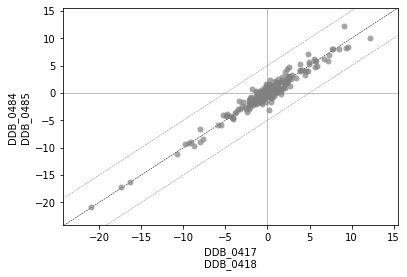

In [23]:
# HMP3071 and SDT551 / FeZnHigh / Batch Phase
_metadata = hr_process_samples_metadata.copy()

_sample_groups = ['WT', 'HMP3071', 'SDT551', 'HMP3427']
_categories = ['phase_0','phase_1','phase_2','phase_3']
_treatments = ['FeZn_low', 'FeZn_high']

_reference_sample_list = _metadata[_metadata['category'] == _categories[0]][_metadata['treatment'] == _treatments[1]][_metadata['sample_group'] == _sample_groups[1]].index.tolist()
_condition_sample_list = _metadata[_metadata['category'] == _categories[0]][_metadata['treatment'] == _treatments[1]][_metadata['sample_group'] == _sample_groups[2]].index.tolist()

ax, table = plot_dima(precise_ddb_nr_json_data,
          _reference_sample_list,
          _condition_sample_list,
          threshold=5.0,
          fdr=0.1,
          table=True,
          adjust=True,
          fit_line=False,
          line45_margin=5,
          label=True)
table

,difference,pvalue,qvalue,0,1


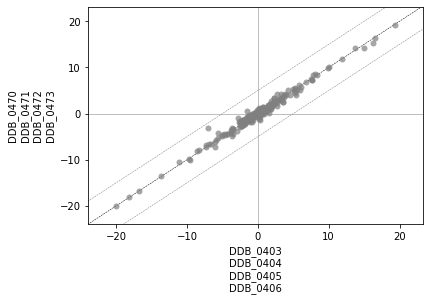

In [24]:
# HMP3071 and SDT551 / FeZnLow / Fed Batch Phase I
_metadata = hr_process_samples_metadata.copy()

_sample_groups = ['WT', 'HMP3071', 'SDT551', 'HMP3427']
_categories = ['phase_0','phase_1','phase_2','phase_3']
_treatments = ['FeZn_low', 'FeZn_high']

_reference_sample_list = _metadata[_metadata['category'] == _categories[1]][_metadata['treatment'] == _treatments[0]][_metadata['sample_group'] == _sample_groups[1]].index.tolist()
_condition_sample_list = _metadata[_metadata['category'] == _categories[1]][_metadata['treatment'] == _treatments[0]][_metadata['sample_group'] == _sample_groups[2]].index.tolist()

ax, table = plot_dima(precise_ddb_nr_json_data,
          _reference_sample_list,
          _condition_sample_list,
          threshold=5.0,
          fdr=0.1,
          table=True,
          adjust=True,
          fit_line=False,
          line45_margin=5,
          label=True)
table

,difference,pvalue,qvalue,0,1


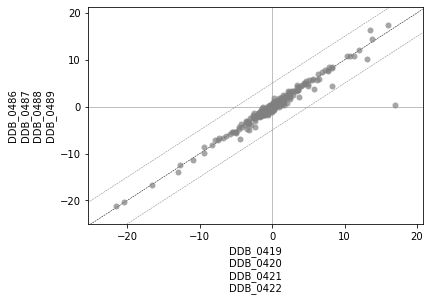

In [25]:
# HMP3071 and SDT551 / FeZnHigh / Fed Batch Phase I
_metadata = hr_process_samples_metadata.copy()

_sample_groups = ['WT', 'HMP3071', 'SDT551', 'HMP3427']
_categories = ['phase_0','phase_1','phase_2','phase_3']
_treatments = ['FeZn_low', 'FeZn_high']

_reference_sample_list = _metadata[_metadata['category'] == _categories[1]][_metadata['treatment'] == _treatments[1]][_metadata['sample_group'] == _sample_groups[1]].index.tolist()
_condition_sample_list = _metadata[_metadata['category'] == _categories[1]][_metadata['treatment'] == _treatments[1]][_metadata['sample_group'] == _sample_groups[2]].index.tolist()

ax, table = plot_dima(precise_ddb_nr_json_data,
          _reference_sample_list,
          _condition_sample_list,
          threshold=5.0,
          fdr=0.1,
          table=True,
          adjust=True,
          fit_line=False,
          line45_margin=5,
          label=True)
table

,difference,pvalue,qvalue,0,1


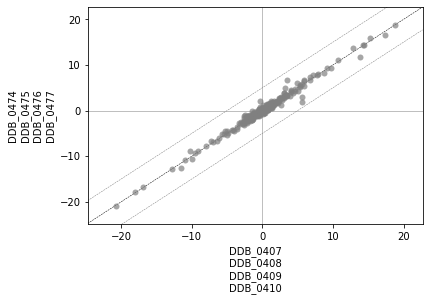

In [26]:
# HMP3071 and SDT551 / FeZnLow / Fed Batch Phase II
_metadata = hr_process_samples_metadata.copy()

_sample_groups = ['WT', 'HMP3071', 'SDT551', 'HMP3427']
_categories = ['phase_0','phase_1','phase_2','phase_3']
_treatments = ['FeZn_low', 'FeZn_high']

_reference_sample_list = _metadata[_metadata['category'] == _categories[2]][_metadata['treatment'] == _treatments[0]][_metadata['sample_group'] == _sample_groups[1]].index.tolist()
_condition_sample_list = _metadata[_metadata['category'] == _categories[2]][_metadata['treatment'] == _treatments[0]][_metadata['sample_group'] == _sample_groups[2]].index.tolist()

ax, table = plot_dima(precise_ddb_nr_json_data,
          _reference_sample_list,
          _condition_sample_list,
          threshold=5.0,
          fdr=0.1,
          table=True,
          adjust=True,
          fit_line=False,
          line45_margin=5,
          label=True)
table

,difference,pvalue,qvalue,0,1


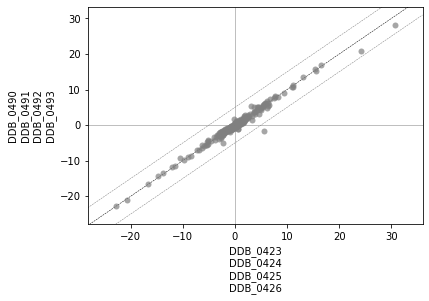

In [27]:
# HMP3071 and SDT551 / FeZnHigh / Fed Batch Phase II
_metadata = hr_process_samples_metadata.copy()

_sample_groups = ['WT', 'HMP3071', 'SDT551', 'HMP3427']
_categories = ['phase_0','phase_1','phase_2','phase_3']
_treatments = ['FeZn_low', 'FeZn_high']

_reference_sample_list = _metadata[_metadata['category'] == _categories[2]][_metadata['treatment'] == _treatments[1]][_metadata['sample_group'] == _sample_groups[1]].index.tolist()
_condition_sample_list = _metadata[_metadata['category'] == _categories[2]][_metadata['treatment'] == _treatments[1]][_metadata['sample_group'] == _sample_groups[2]].index.tolist()

ax, table = plot_dima(precise_ddb_nr_json_data,
          _reference_sample_list,
          _condition_sample_list,
          threshold=5.0,
          fdr=0.1,
          table=True,
          adjust=True,
          fit_line=False,
          line45_margin=5,
          label=True)
table

,difference,pvalue,qvalue,0,1


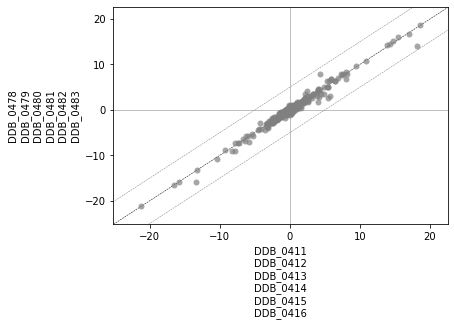

In [28]:
# HMP3071 and SDT551 / FeZnLow / Fed Batch Phase III
_metadata = hr_process_samples_metadata.copy()

_sample_groups = ['WT', 'HMP3071', 'SDT551', 'HMP3427']
_categories = ['phase_0','phase_1','phase_2','phase_3']
_treatments = ['FeZn_low', 'FeZn_high']

_reference_sample_list = _metadata[_metadata['category'] == _categories[3]][_metadata['treatment'] == _treatments[0]][_metadata['sample_group'] == _sample_groups[1]].index.tolist()
_condition_sample_list = _metadata[_metadata['category'] == _categories[3]][_metadata['treatment'] == _treatments[0]][_metadata['sample_group'] == _sample_groups[2]].index.tolist()

ax, table = plot_dima(precise_ddb_nr_json_data,
          _reference_sample_list,
          _condition_sample_list,
          threshold=5.0,
          fdr=0.1,
          table=True,
          adjust=True,
          fit_line=False,
          line45_margin=5,
          label=True)
table

,difference,pvalue,qvalue,0,1


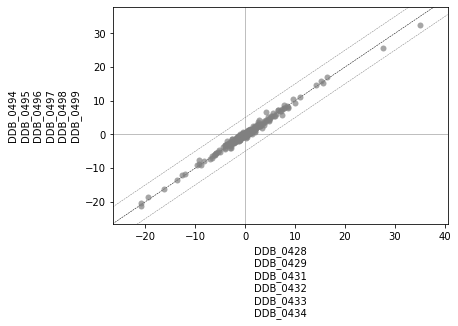

In [29]:
# HMP3071 and SDT551 / FeZnHigh / Fed Batch Phase III
_metadata = hr_process_samples_metadata.copy()

_sample_groups = ['WT', 'HMP3071', 'SDT551', 'HMP3427']
_categories = ['phase_0','phase_1','phase_2','phase_3']
_treatments = ['FeZn_low', 'FeZn_high']

_reference_sample_list = _metadata[_metadata['category'] == _categories[3]][_metadata['treatment'] == _treatments[1]][_metadata['sample_group'] == _sample_groups[1]].index.tolist()
_condition_sample_list = _metadata[_metadata['category'] == _categories[3]][_metadata['treatment'] == _treatments[1]][_metadata['sample_group'] == _sample_groups[2]].index.tolist()

ax, table = plot_dima(precise_ddb_nr_json_data,
          _reference_sample_list,
          _condition_sample_list,
          threshold=5.0,
          fdr=0.1,
          table=True,
          adjust=True,
          fit_line=False,
          line45_margin=5,
          label=True)
table

## Compare all strains across phases and treatments

In [30]:
#Identify all significantly activated iModulons (Batch vs. Fed-Batch)
sample_groups = ['WT', 'HMP3071', 'HMP3427']
categories = ['phase_0','phase_1','phase_2','phase_3']
treatments = ['FeZn_low', 'FeZn_high']

reference_category = categories[0]

metadata = hr_process_samples_metadata #process_samples_metadata

index_filter = precise_ddb_nr_imodulon_table[precise_ddb_nr_imodulon_table['system_category'] != 'Single Gene'][precise_ddb_nr_imodulon_table['functional_category'] != 'Strain Difference'][precise_ddb_nr_imodulon_table['functional_category'] != 'Genome Reduction'].index
process_samples_A_filter = precise_ddb_nr_json_data.A.loc[index_filter]

data_matrix = process_samples_A_filter
threshold = 5
fdr = 0.1

diff_list_group = []

for sample_group in sample_groups:
    for treatment in treatments:
        diff_list_group = []
        diff_list_hd_group = []
        for category in list(set(categories) - set(reference_category)):
            sample_list_0 = precise_ddb_nr_json_data.sample_table[precise_ddb_nr_json_data.sample_table.index.str.contains('SF_')].index.tolist()
            sample_list_1 = metadata[metadata['category'] == reference_category][metadata['treatment'] == treatment][metadata['sample_group'] == sample_group].index.tolist()
            sample_list_2 = metadata[metadata['category'] == category][metadata['treatment'] == treatment][metadata['sample_group'] == sample_group].index.tolist()

            df_diff = pd.DataFrame()

            for name, group in metadata.groupby(["project", "condition"]):
                for i1, i2 in combinations(group.index, 2):
                    df_diff[":".join(name)] = abs(data_matrix[i1] - data_matrix[i2])
            dist = {}

            for k in data_matrix.index:
                dist[k] = stats.lognorm(*stats.lognorm.fit(df_diff.loc[k].values)).cdf

            df_stat = pd.DataFrame(index=data_matrix.index)
            df_stat_hd = pd.DataFrame(index=data_matrix.index)

            for k in df_stat.index:
                a1 = data_matrix.loc[k, sample_list_0].mean()
                a2 = data_matrix.loc[k, sample_list_2].mean()
                df_stat.loc[k, "difference"] = a2 - a1
                df_stat.loc[k, "pvalue"] = 1 - dist[k](abs(a1 - a2))
            df_fdr = FDR(df_stat, fdr)

            for k in df_stat_hd.index:
                a1 = data_matrix.loc[k, sample_list_1].mean()
                a2 = data_matrix.loc[k, sample_list_2].mean()
                df_stat_hd.loc[k, "difference"] = a2 - a1
                df_stat_hd.loc[k, "pvalue"] = 1 - dist[k](abs(a1 - a2))
            df_fdr_hd = FDR(df_stat_hd, fdr)

            diff_list_group.extend(df_fdr[(abs(df_fdr.difference) >= threshold)].sort_values(
                "difference", ascending=False
            ).index)

            diff_list_hd_group.extend(df_fdr_hd[(abs(df_fdr_hd.difference) >= threshold)].sort_values(
                "difference", ascending=False
            ).index)

        diff_list_group = sorted(list(set(diff_list_group)), key=str.lower)
        diff_list_hd_group = sorted(list(set(diff_list_hd_group)), key=str.lower)

        print(f'{sample_group} / {treatment}: {diff_list_group}')
        print(f'{sample_group} / {treatment} / HD: {diff_list_hd_group}')

WT / FeZn_low: ['Alanine', 'Anaerobic', 'Biotin', 'Copper', 'crp KO-1', 'Crp-1', 'Crp-2', 'Curli-1', 'Curli-2', 'Electron Transfer', 'FadR', 'FDH-N/NRA', 'Fe-S Cluster', 'Ferric Citrate', 'Fur-1', 'Fur-2', 'Fur-3', 'GadXW-2', 'GlcC', 'Glyoxylate', 'Iron Uptake-2', 'IS1', 'Leu/Val/Ile-2', 'Magnesium', 'MalT', 'Membrane', 'NDH-1', 'Nickel/Cobalt', 'NrdR', 'NRZ', 'NtrC-1', 'ompR KO', 'Osmoprotectant-1', 'PhoB-1', 'PhoB-2', 'ppGpp', 'Propionate', 'PTS II', 'Purine', 'Putrescine', 'Pyrimidine', 'Quorum Sensing', 'RhaT', 'Suf System', 'Thiamine-1', 'Thiamine-2', 'Translation', 'Zinc-1']
WT / FeZn_low / HD: ['ArgR', 'Cellulose', 'crp KO-1', 'Crp-1', 'Crp-2', 'Curli-1', 'Curli-2', 'FadR', 'FDH-N/NRA', 'Fur-1', 'Fur-2', 'GadXW-2', 'GlcC', 'Magnesium', 'MalT', 'NDH-1', 'NrdR', 'NtrC-1', 'Osmoprotectant-1', 'PhoB-1', 'PhoB-2', 'ppGpp', 'Propionate', 'PTS II', 'Purine', 'Putrescine', 'Pyrimidine', 'Quorum Sensing', 'RhaT', 'Thiamine-1', 'Translation', 'Zinc-1']
WT / FeZn_high: ['Alanine', 'Anaerob

## Identify inconsistent iM activities – WT

,difference,pvalue,qvalue,0,1
Crp-2,14.686228,0.002085,0.027725,-0.790953,13.895275
Crp-1,12.505379,0.001186,0.026553,0.553747,13.059126
Propionate,12.000369,0.000145,0.012821,-1.305552,10.694817
GlcC,9.850635,0.000126,0.012821,4.441057,14.291692
MalT,9.694936,0.002694,0.028664,1.071218,10.766154
Putrescine,9.175409,0.001413,0.026553,-3.170137,6.005271
Quorum Sensing,9.042022,0.000092,0.012821,-0.448462,8.593560
Curli-1,9.035263,0.000345,0.016436,-7.311502,1.723762
NtrC-1,7.231910,0.002006,0.027725,-2.105439,5.126471
Zinc-1,6.863972,0.002999,0.030686,13.224807,20.088780


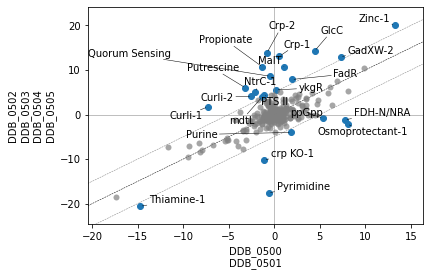

In [31]:
# WT / FeZnLow Medium / Phase I
_metadata = hr_process_samples_metadata.copy()

_sample_groups = ['WT', 'HMP3071', 'SDT551', 'HMP3427']
_categories = ['phase_0','phase_1','phase_2','phase_3']
_treatments = ['FeZn_low', 'FeZn_high']

_reference_sample_list = _metadata[_metadata['category'] == _categories[0]][_metadata['treatment'] == _treatments[0]][_metadata['sample_group'] == _sample_groups[0]].index.tolist()
_condition_sample_list = _metadata[_metadata['category'] == _categories[1]][_metadata['treatment'] == _treatments[0]][_metadata['sample_group'] == _sample_groups[0]].index.tolist()

ax, table = plot_dima(precise_ddb_nr_json_data,
          _reference_sample_list,
          _condition_sample_list,
          threshold=5.0,
          fdr=0.5,
          table=True,
          adjust=True,
          fit_line=False,
          line45_margin=5,
          label=True)
table

,difference,pvalue,qvalue,0,1
Propionate,11.995037,0.000145,0.018781,-0.886340,11.108698
Crp-2,11.416363,0.003870,0.046033,-0.763010,10.653353
Crp-1,10.829784,0.001755,0.039700,0.477840,11.307623
Putrescine,10.314341,0.000989,0.033204,-3.911219,6.403122
Quorum Sensing,9.463649,0.000076,0.018781,-0.506817,8.956832
MalT,9.335152,0.002960,0.039700,1.339037,10.674188
RpoS,8.918652,0.012685,0.063663,-0.947944,7.970709
Curli-1,8.727351,0.000395,0.020649,-7.499781,1.227570
NtrC-1,7.206573,0.002027,0.039700,-2.008570,5.198003
GadXW-2,6.754157,0.008817,0.059529,7.386976,14.141132


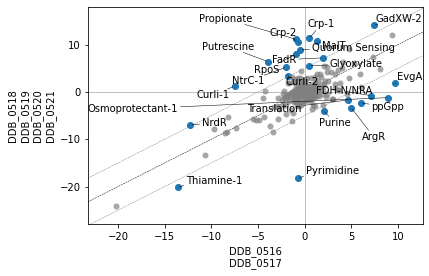

In [32]:
# WT / FeZnLow Medium / Phase I
_metadata = hr_process_samples_metadata.copy()

_sample_groups = ['WT', 'HMP3071', 'SDT551', 'HMP3427']
_categories = ['phase_0','phase_1','phase_2','phase_3']
_treatments = ['FeZn_low', 'FeZn_high']

_reference_sample_list = _metadata[_metadata['category'] == _categories[0]][_metadata['treatment'] == _treatments[1]][_metadata['sample_group'] == _sample_groups[0]].index.tolist()
_condition_sample_list = _metadata[_metadata['category'] == _categories[1]][_metadata['treatment'] == _treatments[1]][_metadata['sample_group'] == _sample_groups[0]].index.tolist()

ax, table = plot_dima(precise_ddb_nr_json_data,
          _reference_sample_list,
          _condition_sample_list,
          threshold=5.0,
          fdr=0.5,
          table=True,
          adjust=True,
          fit_line=False,
          line45_margin=5,
          label=True)
table

,difference,pvalue,qvalue,0,1
Crp-2,14.686987,0.002084,0.028709,-0.790953,13.896034
Curli-2,13.925603,0.000204,0.009057,-2.508538,11.417065
Crp-1,12.863514,0.001096,0.022640,0.553747,13.417261
Propionate,11.663345,0.000161,0.009057,-1.305552,10.357793
GlcC,11.650547,0.000063,0.009057,4.441057,16.091605
Fur-1,10.803297,0.005350,0.039647,-17.417053,-6.613756
Curli-1,10.431003,0.000194,0.009057,-7.311502,3.119501
Quorum Sensing,9.382186,0.000078,0.009057,-0.448462,8.933724
MalT,8.292907,0.003950,0.033896,1.071218,9.364124
NrdR,6.940650,0.002892,0.029586,-11.698353,-4.757703


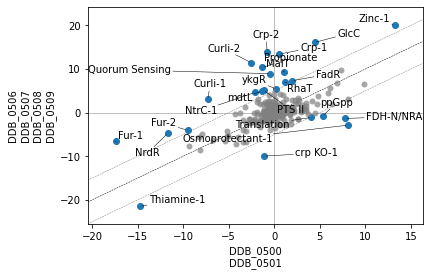

In [33]:
# WT / FeZnLow Medium / Phase II
_metadata = hr_process_samples_metadata.copy()

_sample_groups = ['WT', 'HMP3071', 'SDT551', 'HMP3427']
_categories = ['phase_0','phase_1','phase_2','phase_3']
_treatments = ['FeZn_low', 'FeZn_high']

_reference_sample_list = _metadata[_metadata['category'] == _categories[0]][_metadata['treatment'] == _treatments[0]][_metadata['sample_group'] == _sample_groups[0]].index.tolist()
_condition_sample_list = _metadata[_metadata['category'] == _categories[2]][_metadata['treatment'] == _treatments[0]][_metadata['sample_group'] == _sample_groups[0]].index.tolist()

ax, table = plot_dima(precise_ddb_nr_json_data,
          _reference_sample_list,
          _condition_sample_list,
          threshold=5.0,
          fdr=0.5,
          table=True,
          adjust=True,
          fit_line=False,
          line45_margin=5,
          label=True)
table

,difference,pvalue,qvalue,0,1
Curli-2,14.219860,0.000189,0.010073,-1.796115,12.423744
Crp-2,13.029922,0.002810,0.037375,-0.763010,12.266912
Propionate,11.466680,0.000172,0.010073,-0.886340,10.580341
Crp-1,11.435690,0.001516,0.026165,0.477840,11.913530
Curli-1,11.160920,0.000147,0.010073,-7.499781,3.661140
Quorum Sensing,9.501537,0.000074,0.010073,-0.506817,8.994721
MalT,7.823087,0.004540,0.044726,1.339037,9.162124
GlcC,5.910103,0.000884,0.023126,4.722321,10.632423
RhaT,5.611468,0.000310,0.013725,1.385649,6.997118
PTS II,5.558280,0.001542,0.026165,-1.374429,4.183851


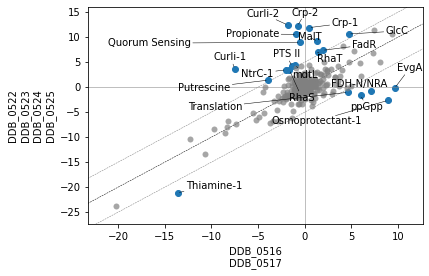

In [34]:
# WT / FeZnLow Medium / Phase II
_metadata = hr_process_samples_metadata.copy()

_sample_groups = ['WT', 'HMP3071', 'SDT551', 'HMP3427']
_categories = ['phase_0','phase_1','phase_2','phase_3']
_treatments = ['FeZn_low', 'FeZn_high']

_reference_sample_list = _metadata[_metadata['category'] == _categories[0]][_metadata['treatment'] == _treatments[1]][_metadata['sample_group'] == _sample_groups[0]].index.tolist()
_condition_sample_list = _metadata[_metadata['category'] == _categories[2]][_metadata['treatment'] == _treatments[1]][_metadata['sample_group'] == _sample_groups[0]].index.tolist()

ax, table = plot_dima(precise_ddb_nr_json_data,
          _reference_sample_list,
          _condition_sample_list,
          threshold=5.0,
          fdr=0.5,
          table=True,
          adjust=True,
          fit_line=False,
          line45_margin=5,
          label=True)
table

,difference,pvalue,qvalue,0,1
Curli-2,18.952073,0.000064,0.008385,-2.508538,16.443535
Fur-1,11.853130,0.004229,0.034087,-17.417053,-5.563924
PhoB-2,11.509391,0.001732,0.022770,-0.498902,11.010489
Curli-1,11.493188,0.000130,0.008644,-7.311502,4.181687
Crp-2,11.470373,0.003827,0.033932,-0.790953,10.679420
Propionate,10.813416,0.000213,0.009903,-1.305552,9.507865
GlcC,10.564849,0.000095,0.008385,4.441057,15.005906
Crp-1,8.850974,0.002975,0.028967,0.553747,9.404721
NrdR,7.874123,0.002007,0.024261,-11.698353,-3.824230
Quorum Sensing,7.283535,0.000223,0.009903,-0.448462,6.835072


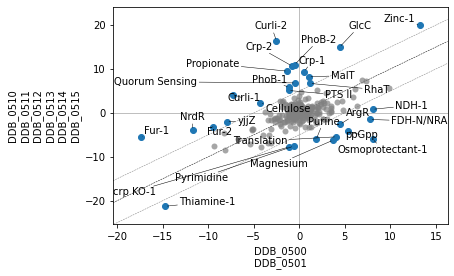

In [35]:
# WT / FeZnLow Medium / Phase III
_metadata = hr_process_samples_metadata.copy()

_sample_groups = ['WT', 'HMP3071', 'SDT551', 'HMP3427']
_categories = ['phase_0','phase_1','phase_2','phase_3']
_treatments = ['FeZn_low', 'FeZn_high']

_reference_sample_list = _metadata[_metadata['category'] == _categories[0]][_metadata['treatment'] == _treatments[0]][_metadata['sample_group'] == _sample_groups[0]].index.tolist()
_condition_sample_list = _metadata[_metadata['category'] == _categories[3]][_metadata['treatment'] == _treatments[0]][_metadata['sample_group'] == _sample_groups[0]].index.tolist()

ax, table = plot_dima(precise_ddb_nr_json_data,
          _reference_sample_list,
          _condition_sample_list,
          threshold=5.0,
          fdr=0.5,
          table=True,
          adjust=True,
          fit_line=False,
          line45_margin=5,
          label=True)
table

,difference,pvalue,qvalue,0,1
Curli-2,21.227286,0.000041,0.005462,-1.796115,19.431171
Curli-1,13.502515,0.000065,0.005788,-7.499781,6.002735
Propionate,12.099510,0.000140,0.007869,-0.886340,11.213171
PhoB-2,11.652562,0.001675,0.026217,-0.795178,10.857384
Crp-2,10.987811,0.004238,0.039088,-0.763010,10.224801
Crp-1,8.313734,0.003486,0.034344,0.477840,8.791574
Quorum Sensing,8.062869,0.000148,0.007869,-0.506817,7.556053
Zinc-1,7.465386,0.002354,0.031995,0.521136,7.986522
PhoB-1,6.968795,0.000345,0.013103,-1.313123,5.655672
PTS II,6.131169,0.001079,0.022732,-1.374429,4.756740


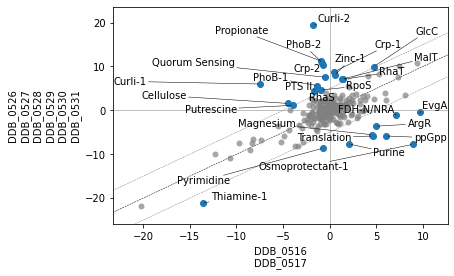

In [36]:
# WT / FeZnLow Medium / Phase III
_metadata = hr_process_samples_metadata.copy()

_sample_groups = ['WT', 'HMP3071', 'SDT551', 'HMP3427']
_categories = ['phase_0','phase_1','phase_2','phase_3']
_treatments = ['FeZn_low', 'FeZn_high']

_reference_sample_list = _metadata[_metadata['category'] == _categories[0]][_metadata['treatment'] == _treatments[1]][_metadata['sample_group'] == _sample_groups[0]].index.tolist()
_condition_sample_list = _metadata[_metadata['category'] == _categories[3]][_metadata['treatment'] == _treatments[1]][_metadata['sample_group'] == _sample_groups[0]].index.tolist()

ax, table = plot_dima(precise_ddb_nr_json_data,
          _reference_sample_list,
          _condition_sample_list,
          threshold=5.0,
          fdr=0.5,
          table=True,
          adjust=True,
          fit_line=False,
          line45_margin=5,
          label=True)
table

## Identify inconsistent iM activities – HMP3071

,difference,pvalue,qvalue,0,1
Crp-2,14.996661,0.001977,0.028262,-0.080689,14.915972
Nucleoside,11.685604,0.000186,0.012625,4.810559,16.496164
Propionate,11.158530,0.000190,0.012625,-1.210598,9.947931
GlcC,9.851913,0.000126,0.012625,6.363475,16.215387
PyrR,9.524596,0.000069,0.012625,0.466931,9.991528
FadR,7.664296,0.000709,0.017504,0.009167,7.673463
MalT,7.644000,0.004795,0.042852,6.068234,13.712235
Crp-1,7.605343,0.004348,0.042835,4.231017,11.836360
GlpR,7.586663,0.001069,0.018389,0.490650,8.077313
PaaX,6.849619,0.001089,0.018389,-1.633600,5.216019


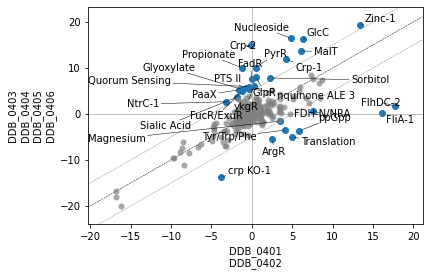

In [37]:
# HMP3071 / FeZnLow Medium / Phase I
_metadata = hr_process_samples_metadata.copy()

_sample_groups = ['WT', 'HMP3071', 'SDT551', 'HMP3427']
_categories = ['phase_0','phase_1','phase_2','phase_3']
_treatments = ['FeZn_low', 'FeZn_high']

_reference_sample_list = _metadata[_metadata['category'] == _categories[0]][_metadata['treatment'] == _treatments[0]][_metadata['sample_group'] == _sample_groups[1]].index.tolist()
_condition_sample_list = _metadata[_metadata['category'] == _categories[1]][_metadata['treatment'] == _treatments[0]][_metadata['sample_group'] == _sample_groups[1]].index.tolist()

ax, table = plot_dima(precise_ddb_nr_json_data,
          _reference_sample_list,
          _condition_sample_list,
          threshold=5.0,
          fdr=0.5,
          table=True,
          adjust=True,
          fit_line=False,
          line45_margin=5,
          label=True)
table

,difference,pvalue,qvalue,0,1
Crp-2,12.169430,0.003320,0.046479,1.383504,13.552934
Propionate,11.252590,0.000184,0.020144,-0.935514,10.317076
PyrR,10.277362,0.000049,0.013060,0.520828,10.798191
Nucleoside,10.099182,0.000314,0.020144,5.840534,15.939716
PaaX,8.697049,0.000454,0.020144,-0.788609,7.908440
EvgA,7.635205,0.005132,0.048881,9.287942,16.923147
Crp-1,7.473384,0.004538,0.048881,4.491998,11.965382
MalT,7.108754,0.005679,0.050358,6.710983,13.819737
Glyoxylate,6.682813,0.000351,0.020144,-0.422956,6.259857
GlpR,6.479273,0.001728,0.034935,0.845318,7.324591


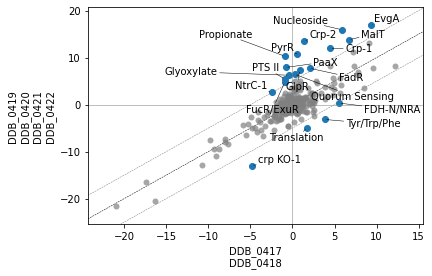

In [38]:
# HMP3071 / FeZnLow Medium / Phase I
_metadata = hr_process_samples_metadata.copy()

_sample_groups = ['WT', 'HMP3071', 'SDT551', 'HMP3427']
_categories = ['phase_0','phase_1','phase_2','phase_3']
_treatments = ['FeZn_low', 'FeZn_high']

_reference_sample_list = _metadata[_metadata['category'] == _categories[0]][_metadata['treatment'] == _treatments[1]][_metadata['sample_group'] == _sample_groups[1]].index.tolist()
_condition_sample_list = _metadata[_metadata['category'] == _categories[1]][_metadata['treatment'] == _treatments[1]][_metadata['sample_group'] == _sample_groups[1]].index.tolist()

ax, table = plot_dima(precise_ddb_nr_json_data,
          _reference_sample_list,
          _condition_sample_list,
          threshold=5.0,
          fdr=0.5,
          table=True,
          adjust=True,
          fit_line=False,
          line45_margin=5,
          label=True)
table

,difference,pvalue,qvalue,0,1
Crp-2,14.305724,0.002227,0.027355,-0.080689,14.225035
GlcC,11.051224,0.000078,0.010423,6.363475,17.414699
Propionate,10.857265,0.000210,0.017900,-1.210598,9.646667
Nucleoside,10.469745,0.000276,0.017900,4.810559,15.280304
PyrR,10.284009,0.000049,0.010423,0.466931,10.750940
GlpR,8.634659,0.000711,0.017900,0.490650,9.125309
Crp-1,8.549303,0.003249,0.034715,4.231017,12.780319
MalT,8.345165,0.003891,0.035690,6.068234,14.413399
ykgR,6.861954,0.014347,0.072008,0.259894,7.121848
FadR,6.794521,0.001073,0.017900,0.009167,6.803688


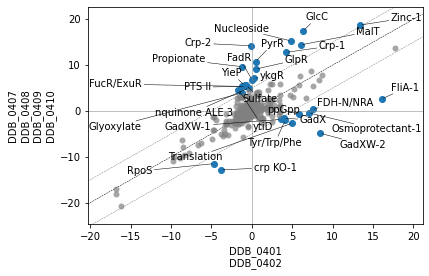

In [39]:
# HMP3071 / FeZnLow Medium / Phase II
_metadata = hr_process_samples_metadata.copy()

_sample_groups = ['WT', 'HMP3071', 'SDT551', 'HMP3427']
_categories = ['phase_0','phase_1','phase_2','phase_3']
_treatments = ['FeZn_low', 'FeZn_high']

_reference_sample_list = _metadata[_metadata['category'] == _categories[0]][_metadata['treatment'] == _treatments[0]][_metadata['sample_group'] == _sample_groups[1]].index.tolist()
_condition_sample_list = _metadata[_metadata['category'] == _categories[2]][_metadata['treatment'] == _treatments[0]][_metadata['sample_group'] == _sample_groups[1]].index.tolist()

ax, table = plot_dima(precise_ddb_nr_json_data,
          _reference_sample_list,
          _condition_sample_list,
          threshold=5.0,
          fdr=0.5,
          table=True,
          adjust=True,
          fit_line=False,
          line45_margin=5,
          label=True)
table

,difference,pvalue,qvalue,0,1
FlhDC-2,21.481431,0.001142,0.018022,9.140433,30.621864
FliA-1,19.384871,0.000332,0.015683,4.798883,24.183754
Crp-2,14.020565,0.002343,0.025966,1.383504,15.404069
Propionate,12.076449,0.000141,0.015683,-0.935514,11.140935
Nucleoside,10.577173,0.000266,0.015683,5.840534,16.417707
PyrR,10.557537,0.000044,0.011573,0.520828,11.078366
MalT,8.820781,0.003402,0.028768,6.710983,15.531764
Crp-1,8.630322,0.003173,0.028768,4.491998,13.122320
GlpR,8.558969,0.000731,0.018005,0.845318,9.404286
PTS II,7.331115,0.000546,0.016150,-0.908162,6.422953


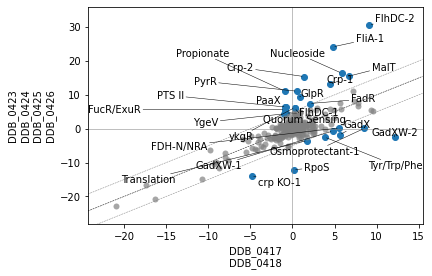

In [40]:
# HMP3071 / FeZnLow Medium / Phase II
_metadata = hr_process_samples_metadata.copy()

_sample_groups = ['WT', 'HMP3071', 'SDT551', 'HMP3427']
_categories = ['phase_0','phase_1','phase_2','phase_3']
_treatments = ['FeZn_low', 'FeZn_high']

_reference_sample_list = _metadata[_metadata['category'] == _categories[0]][_metadata['treatment'] == _treatments[1]][_metadata['sample_group'] == _sample_groups[1]].index.tolist()
_condition_sample_list = _metadata[_metadata['category'] == _categories[2]][_metadata['treatment'] == _treatments[1]][_metadata['sample_group'] == _sample_groups[1]].index.tolist()

ax, table = plot_dima(precise_ddb_nr_json_data,
          _reference_sample_list,
          _condition_sample_list,
          threshold=5.0,
          fdr=0.5,
          table=True,
          adjust=True,
          fit_line=False,
          line45_margin=5,
          label=True)
table

,difference,pvalue,qvalue,0,1
Crp-2,14.829658,0.002034,0.023522,-0.080689,14.748969
Propionate,10.619482,0.000228,0.013922,-1.210598,9.408884
GlcC,10.595929,0.000093,0.008846,6.363475,16.959403
Nucleoside,10.560280,0.000268,0.013922,4.810559,15.370840
PyrR,10.410557,0.000046,0.008846,0.466931,10.877488
...,...,...,...,...,...
crp KO-1,-9.521314,0.000993,0.020063,-3.805372,-13.326686
RpoS,-11.127887,0.007747,0.048963,-4.702263,-15.830150
FliA-1,-12.037550,0.001358,0.020063,16.051652,4.014102
Osmoprotectant-1,-12.354864,0.000100,0.008846,7.052820,-5.302044


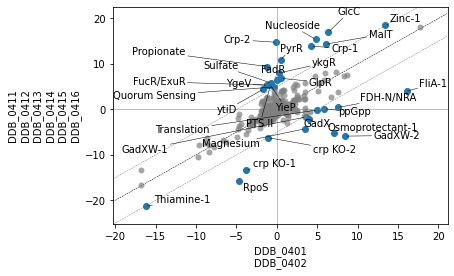

In [41]:
# HMP3071 / FeZnLow Medium / Phase III
_metadata = hr_process_samples_metadata.copy()

_sample_groups = ['WT', 'HMP3071', 'SDT551', 'HMP3427']
_categories = ['phase_0','phase_1','phase_2','phase_3']
_treatments = ['FeZn_low', 'FeZn_high']

_reference_sample_list = _metadata[_metadata['category'] == _categories[0]][_metadata['treatment'] == _treatments[0]][_metadata['sample_group'] == _sample_groups[1]].index.tolist()
_condition_sample_list = _metadata[_metadata['category'] == _categories[3]][_metadata['treatment'] == _treatments[0]][_metadata['sample_group'] == _sample_groups[1]].index.tolist()

ax, table = plot_dima(precise_ddb_nr_json_data,
          _reference_sample_list,
          _condition_sample_list,
          threshold=5.0,
          fdr=0.5,
          table=True,
          adjust=True,
          fit_line=False,
          line45_margin=5,
          label=True)
table

,difference,pvalue,qvalue,0,1
FlhDC-2,25.825400,0.000694,0.011540,9.140433,34.965832
FliA-1,22.901721,0.000195,0.008651,4.798883,27.700605
Crp-2,13.792348,0.002441,0.020945,1.383504,15.175853
Nucleoside,10.644633,0.000261,0.008662,5.840534,16.485167
Propionate,10.559994,0.000233,0.008662,-0.935514,9.624480
PyrR,10.382881,0.000047,0.006830,0.520828,10.903710
Crp-1,9.660782,0.002374,0.020945,4.491998,14.152780
YgeV,8.899359,0.000388,0.009912,-1.032769,7.866589
MalT,8.846707,0.003378,0.024957,6.710983,15.557690
FlhDC-1,8.232853,0.000158,0.008651,-0.785455,7.447398


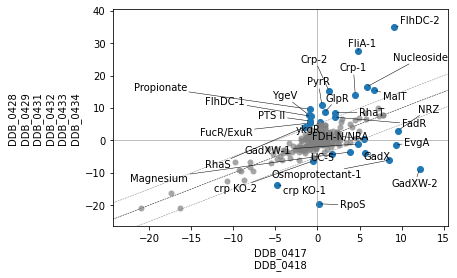

In [42]:
# HMP3071 / FeZnLow Medium / Phase III
_metadata = hr_process_samples_metadata.copy()

_sample_groups = ['WT', 'HMP3071', 'SDT551', 'HMP3427']
_categories = ['phase_0','phase_1','phase_2','phase_3']
_treatments = ['FeZn_low', 'FeZn_high']

_reference_sample_list = _metadata[_metadata['category'] == _categories[0]][_metadata['treatment'] == _treatments[1]][_metadata['sample_group'] == _sample_groups[1]].index.tolist()
_condition_sample_list = _metadata[_metadata['category'] == _categories[3]][_metadata['treatment'] == _treatments[1]][_metadata['sample_group'] == _sample_groups[1]].index.tolist()

ax, table = plot_dima(precise_ddb_nr_json_data,
          _reference_sample_list,
          _condition_sample_list,
          threshold=5.0,
          fdr=0.5,
          table=True,
          adjust=True,
          fit_line=False,
          line45_margin=5,
          label=True)
table

## Identify inconsistent iM activities – HMP3427

,difference,pvalue,qvalue,0,1
GlcC,15.130592,0.000020,0.005294,0.304690,15.435282
Zinc-1,11.538687,0.000611,0.036030,7.962340,19.501027
MalT,11.197168,0.001868,0.044472,-0.679245,10.517923
Nucleoside,10.674624,0.000258,0.022867,3.408134,14.082759
Crp-2,10.649710,0.004561,0.052744,0.314293,10.964003
YieP,8.260089,0.000191,0.022867,-1.344869,6.915220
Crp-1,8.201631,0.003607,0.050898,3.271599,11.473230
Propionate,7.333032,0.000832,0.036030,-1.936426,5.396606
ykgR,6.705161,0.015095,0.095601,1.468987,8.174148
GlpR,6.686567,0.001573,0.044472,-1.227686,5.458881


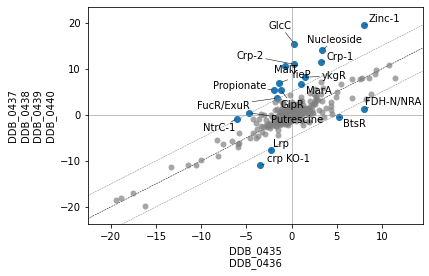

In [43]:
# HMP3427 / FeZnLow Medium / Phase I
_metadata = hr_process_samples_metadata.copy()

_sample_groups = ['WT', 'HMP3071', 'SDT551', 'HMP3427']
_categories = ['phase_0','phase_1','phase_2','phase_3']
_treatments = ['FeZn_low', 'FeZn_high']

_reference_sample_list = _metadata[_metadata['category'] == _categories[0]][_metadata['treatment'] == _treatments[0]][_metadata['sample_group'] == _sample_groups[3]].index.tolist()
_condition_sample_list = _metadata[_metadata['category'] == _categories[1]][_metadata['treatment'] == _treatments[0]][_metadata['sample_group'] == _sample_groups[3]].index.tolist()

ax, table = plot_dima(precise_ddb_nr_json_data,
          _reference_sample_list,
          _condition_sample_list,
          threshold=5.0,
          fdr=0.5,
          table=True,
          adjust=True,
          fit_line=False,
          line45_margin=5,
          label=True)
table

,difference,pvalue,qvalue,0,1
MalT,12.864658,0.001297,0.046325,-0.935402,11.929255
Crp-2,12.805991,0.002932,0.046325,0.399282,13.205273
Nucleoside,11.947036,0.000171,0.026474,3.392886,15.339922
FlhDC-2,11.563694,0.005269,0.054957,-2.270467,9.293227
Crp-1,8.820711,0.003001,0.046325,2.839237,11.659948
GlcC,8.793017,0.000199,0.026474,0.050318,8.843335
NtrC-1,6.168524,0.003202,0.046325,-6.043045,0.125479
Putrescine,6.119762,0.004472,0.051721,-5.539651,0.580111
GadXW-2,5.879423,0.011991,0.070880,-9.670544,-3.791121
GlpR,5.582233,0.002670,0.046325,-1.109622,4.472610


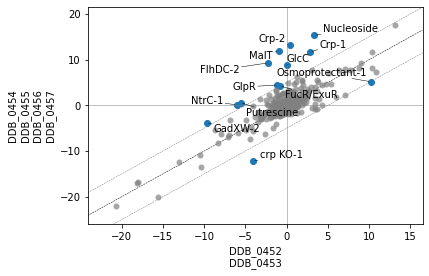

In [44]:
# HMP3427 / FeZnLow Medium / Phase I
_metadata = hr_process_samples_metadata.copy()

_sample_groups = ['WT', 'HMP3071', 'SDT551', 'HMP3427']
_categories = ['phase_0','phase_1','phase_2','phase_3']
_treatments = ['FeZn_low', 'FeZn_high']

_reference_sample_list = _metadata[_metadata['category'] == _categories[0]][_metadata['treatment'] == _treatments[1]][_metadata['sample_group'] == _sample_groups[3]].index.tolist()
_condition_sample_list = _metadata[_metadata['category'] == _categories[1]][_metadata['treatment'] == _treatments[1]][_metadata['sample_group'] == _sample_groups[3]].index.tolist()

ax, table = plot_dima(precise_ddb_nr_json_data,
          _reference_sample_list,
          _condition_sample_list,
          threshold=5.0,
          fdr=0.5,
          table=True,
          adjust=True,
          fit_line=False,
          line45_margin=5,
          label=True)
table

,difference,pvalue,qvalue,0,1
GlcC,13.869008,0.000029,0.007821,0.304690,14.173698
Zinc-1,11.057952,0.000702,0.027049,7.962340,19.020292
Nucleoside,8.772005,0.000512,0.027049,3.408134,12.180139
MalT,8.557676,0.003662,0.060877,-0.679245,7.878431
Crp-1,8.408099,0.003389,0.060090,3.271599,11.679697
MarA,8.158043,0.000199,0.021066,1.028108,9.186151
Crp-2,7.809993,0.009162,0.090266,0.314293,8.124286
UC-2,7.383629,0.000966,0.032124,-3.108968,4.274661
ykgR,6.379696,0.016818,0.109819,1.468987,7.848683
YieP,5.953946,0.000673,0.027049,-1.344869,4.609077


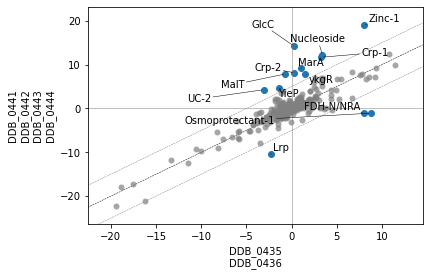

In [45]:
# HMP3427 / FeZnLow Medium / Phase II
_metadata = hr_process_samples_metadata.copy()

_sample_groups = ['WT', 'HMP3071', 'SDT551', 'HMP3427']
_categories = ['phase_0','phase_1','phase_2','phase_3']
_treatments = ['FeZn_low', 'FeZn_high']

_reference_sample_list = _metadata[_metadata['category'] == _categories[0]][_metadata['treatment'] == _treatments[0]][_metadata['sample_group'] == _sample_groups[3]].index.tolist()
_condition_sample_list = _metadata[_metadata['category'] == _categories[2]][_metadata['treatment'] == _treatments[0]][_metadata['sample_group'] == _sample_groups[3]].index.tolist()

ax, table = plot_dima(precise_ddb_nr_json_data,
          _reference_sample_list,
          _condition_sample_list,
          threshold=5.0,
          fdr=0.5,
          table=True,
          adjust=True,
          fit_line=False,
          line45_margin=5,
          label=True)
table

,difference,pvalue,qvalue,0,1
FlhDC-2,21.968208,0.001076,0.040988,-2.270467,19.697741
FliA-1,12.892472,0.001119,0.040988,-1.305504,11.586968
MalT,11.437949,0.001768,0.042748,-0.935402,10.502547
Crp-2,11.273166,0.003988,0.046123,0.399282,11.672448
Nucleoside,10.791074,0.000248,0.020779,3.392886,14.183959
GlcC,9.781652,0.000130,0.020779,0.050318,9.831969
Crp-1,9.167686,0.002719,0.046123,2.839237,12.006923
MarA,7.319236,0.000312,0.020779,1.306418,8.625654
UC-2,7.080621,0.001116,0.040988,-2.520339,4.560282
NtrC-1,5.140163,0.005333,0.050945,-6.043045,-0.902881


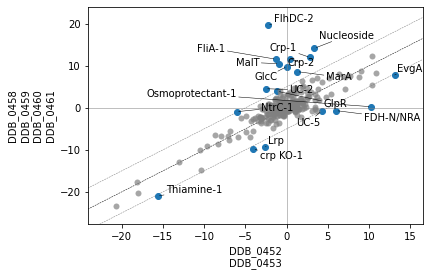

In [46]:
# HMP3427 / FeZnLow Medium / Phase II
_metadata = hr_process_samples_metadata.copy()

_sample_groups = ['WT', 'HMP3071', 'SDT551', 'HMP3427']
_categories = ['phase_0','phase_1','phase_2','phase_3']
_treatments = ['FeZn_low', 'FeZn_high']

_reference_sample_list = _metadata[_metadata['category'] == _categories[0]][_metadata['treatment'] == _treatments[1]][_metadata['sample_group'] == _sample_groups[3]].index.tolist()
_condition_sample_list = _metadata[_metadata['category'] == _categories[2]][_metadata['treatment'] == _treatments[1]][_metadata['sample_group'] == _sample_groups[3]].index.tolist()

ax, table = plot_dima(precise_ddb_nr_json_data,
          _reference_sample_list,
          _condition_sample_list,
          threshold=5.0,
          fdr=0.5,
          table=True,
          adjust=True,
          fit_line=False,
          line45_margin=5,
          label=True)
table

,difference,pvalue,qvalue,0,1
Zinc-1,12.011565,0.000535,0.023719,7.962340,19.973905
MarA,9.706834,0.000094,0.023719,1.028108,10.734942
UC-2,8.775797,0.000524,0.023719,-3.108968,5.666829
Phage Shock,6.767023,0.000993,0.032755,2.614729,9.381751
YmfT,6.672022,0.001108,0.032755,3.503030,10.175053
SoxS,6.472236,0.000491,0.023719,-0.998037,5.474198
DNA Damage,5.516624,0.000501,0.023719,2.473864,7.990488
Crp-1,-5.098447,0.011014,0.115048,3.271599,-1.826848
FlhDC-2,-5.351488,0.025876,0.140471,1.311978,-4.039511
Dipeptide,-5.831263,0.002662,0.060903,8.520984,2.689722


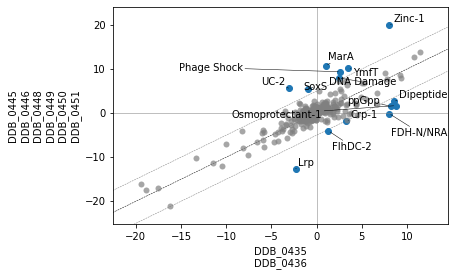

In [47]:
# HMP3427 / FeZnLow Medium / Phase III
_metadata = hr_process_samples_metadata.copy()

_sample_groups = ['WT', 'HMP3071', 'SDT551', 'HMP3427']
_categories = ['phase_0','phase_1','phase_2','phase_3']
_treatments = ['FeZn_low', 'FeZn_high']

_reference_sample_list = _metadata[_metadata['category'] == _categories[0]][_metadata['treatment'] == _treatments[0]][_metadata['sample_group'] == _sample_groups[3]].index.tolist()
_condition_sample_list = _metadata[_metadata['category'] == _categories[3]][_metadata['treatment'] == _treatments[0]][_metadata['sample_group'] == _sample_groups[3]].index.tolist()

ax, table = plot_dima(precise_ddb_nr_json_data,
          _reference_sample_list,
          _condition_sample_list,
          threshold=5.0,
          fdr=0.5,
          table=True,
          adjust=True,
          fit_line=False,
          line45_margin=5,
          label=True)
table

,difference,pvalue,qvalue,0,1
FlhDC-2,17.053367,0.002073,0.034471,-2.270467,14.782900
FliA-1,10.944229,0.001766,0.034471,-1.305504,9.638725
MarA,8.781794,0.000145,0.019327,1.306418,10.088213
UC-2,8.530154,0.000580,0.030866,-2.520339,6.009815
SoxS,6.894513,0.000392,0.026094,-0.778990,6.115523
YmfT,5.600529,0.002061,0.034471,0.958282,6.558811
Alanine,5.397754,0.002815,0.044043,-2.925830,2.471924
Acid Shock RNA,4.836385,0.001976,0.034471,-2.187476,2.648910
GlcC,4.661081,0.001992,0.034471,0.050318,4.711399
DNA Damage,4.415067,0.001151,0.034471,1.994111,6.409179


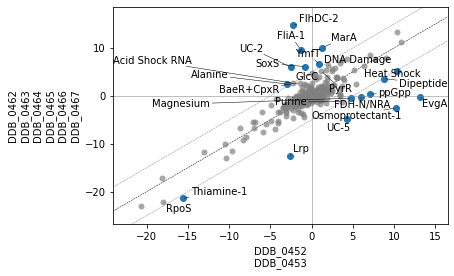

In [48]:
# HMP3427 / FeZnLow Medium / Phase III
_metadata = hr_process_samples_metadata.copy()

_sample_groups = ['WT', 'HMP3071', 'SDT551', 'HMP3427']
_categories = ['phase_0','phase_1','phase_2','phase_3']
_treatments = ['FeZn_low', 'FeZn_high']

_reference_sample_list = _metadata[_metadata['category'] == _categories[0]][_metadata['treatment'] == _treatments[1]][_metadata['sample_group'] == _sample_groups[3]].index.tolist()
_condition_sample_list = _metadata[_metadata['category'] == _categories[3]][_metadata['treatment'] == _treatments[1]][_metadata['sample_group'] == _sample_groups[3]].index.tolist()

ax, table = plot_dima(precise_ddb_nr_json_data,
          _reference_sample_list,
          _condition_sample_list,
          threshold=4.0,
          fdr=0.5,
          table=True,
          adjust=True,
          fit_line=False,
          line45_margin=5,
          label=True)
table

## Correlate high density-specific iModulons

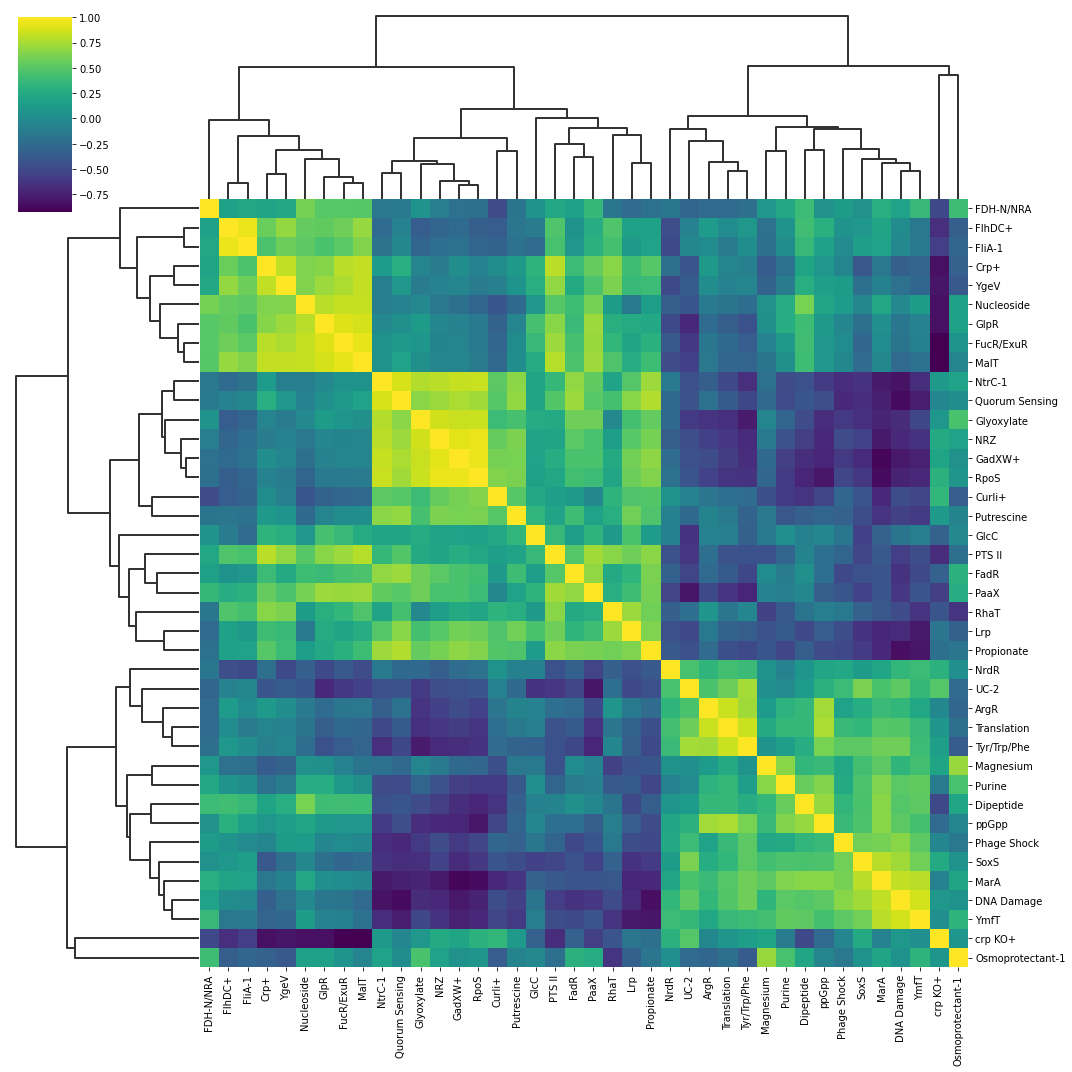

In [50]:
_sample_list = hr_process_samples_metadata[hr_process_samples_metadata['category'] != 'phase_0'].index.tolist()
_data_matrix = hr_process_samples_A.copy()

# Sum iMs encoding functions distributed across multiple iMs
_data_matrix.loc['Crp+',:] = hr_process_samples_A.loc['Crp-1',:] + hr_process_samples_A.loc['Crp-2',:]
_data_matrix.loc['crp KO+',:] = hr_process_samples_A.loc['crp KO-1',:] + hr_process_samples_A.loc['crp KO-2',:]
_data_matrix.loc['Curli+',:] = hr_process_samples_A.loc['Curli-1',:] + hr_process_samples_A.loc['Curli-2',:] + hr_process_samples_A.loc['Cellulose',:]
_data_matrix.loc['FlhDC+',:] = hr_process_samples_A.loc['FlhDC-1',:] + hr_process_samples_A.loc['FlhDC-2',:]
_data_matrix.loc['GadXW+',:] = hr_process_samples_A.loc['GadX',:] + hr_process_samples_A.loc['GadXW-1',:] + hr_process_samples_A.loc['GadXW-2',:]

# _HD_iM_list = ['ArgR', 'Cellulose', 'Crp-1', 'Crp-2', 'Curli-1', 'Curli-2', 'CytR', 'DNA Damage', 'Dipeptide', 'FDH-N/NRA', 'FadR', 'FlhDC-1', 'FlhDC-2', 'FliA-1', 'FucR/ExuR', 'GadX', 'GadXW-1', 'GadXW-2', 'GlcC', 'GlpR', 'Glyoxylate', 'Lrp', 'Magnesium', 'MalT', 'NRZ', 'NrdR', 'NtrC-1', 'Osmoprotectant-1', 'PTS II', 'PaaX', 'Phage Shock', 'Propionate', 'Purine', 'Putrescine', 'Pyrimidine', 'Quorum Sensing', 'RhaT', 'RpoS', 'Salicylic Acid', 'SoxS', 'Translation', 'Tyr/Trp/Phe', 'UC-2', 'YgeV', 'YmfT', 'crp KO-1', 'crp KO-2', 'ppGpp']

_HD_iM_list = ['ArgR', 'crp KO+', 'Crp+', 'Curli+', 'Nucleoside', 'DNA Damage', 'Dipeptide', 'FDH-N/NRA', 'FadR', 'FlhDC+', 'FliA-1', 'FucR/ExuR', 'GadXW+', 'GlcC', 'GlpR', 'Glyoxylate', 'Lrp', 'Magnesium', 'MalT', 'NRZ', 'NrdR', 'NtrC-1', 'Osmoprotectant-1', 'ppGpp', 'PTS II', 'PaaX', 'Phage Shock', 'Propionate', 'Purine', 'Putrescine', 'Quorum Sensing', 'RhaT', 'RpoS', 'MarA', 'SoxS', 'Translation', 'Tyr/Trp/Phe', 'UC-2', 'YgeV', 'YmfT']

_df_corr = _data_matrix.loc[_HD_iM_list,_sample_list].copy()

correlation_df = _df_corr.T.corr(method='spearman')

clustermap = sns.clustermap(correlation_df, method = 'average', cmap='viridis', figsize=(15,15))

for a in clustermap.ax_row_dendrogram.collections:
    a.set_linewidth(2)
for a in clustermap.ax_col_dendrogram.collections:
    a.set_linewidth(2)

plt.draw_if_interactive()

Text(0, 0.5, 'ppGpp Activity')

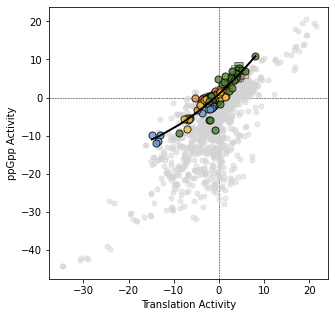

In [55]:
_iM_list = ['Translation', 'ppGpp']
_sample_groups = ['WT', 'HMP3071', 'SDT551', 'HMP3427']
_colors = ['#6a99d0', '#df8344', '#f5c242', '#548235']

_data_matrix = precise_ddb_nr_json_data.copy()
_metadata = hr_process_samples_metadata.copy()
_regression_deg = 2

_, ax = plt.subplots(figsize=(5, 5))

ax.axvline(0, linestyle='--', color='black', zorder=-1, linewidth=0.5)
ax.axhline(0, linestyle='--', color='black', zorder=-1, linewidth=0.5)

## Precise Background Scatter
ax.scatter(_data_matrix.A.loc[_iM_list[0],_data_matrix.A.columns.str.contains('ecoli', regex=False)], _data_matrix.A.loc[_iM_list[1],_data_matrix.A.columns.str.contains('ecoli', regex=False)], c='lightgray', s=25, alpha=0.5, linewidths=1, edgecolors="lightgray")

## Batch Scatter
for _i in range(len(_sample_groups)):
    _sample_list = _metadata[_metadata['sample_group'] == _sample_groups[_i]][_metadata['category'] == 'phase_0'].index.tolist()
    ax.scatter(_data_matrix.A[_sample_list].loc[_iM_list[0]], _data_matrix.A[_sample_list].loc[_iM_list[1]], marker='s', c=_colors[_i], s=50, alpha=0.3, linewidths=1, edgecolors="k")

## Fed Batch Scatter
for _i in range(len(_sample_groups)):
    _sample_list = _metadata[_metadata['sample_group'] == _sample_groups[_i]][_metadata['category'] != 'phase_0'].index.tolist()
    ax.scatter(_data_matrix.A[_sample_list].loc[_iM_list[0]], _data_matrix.A[_sample_list].loc[_iM_list[1]], marker='o', c=_colors[_i], s=50, alpha=0.8, linewidths=1, edgecolors="k")

## Polynomal Regression
df_regression = pd.DataFrame()
df_regression['X'] = _data_matrix.A[_metadata[_metadata['sample_group'].isin(_sample_groups)][_metadata['category'] != 'phase_0'].index.tolist()].loc[_iM_list[0]]
df_regression['Y'] = _data_matrix.A[_metadata[_metadata['sample_group'].isin(_sample_groups)][_metadata['category'] != 'phase_0'].index.tolist()].loc[_iM_list[1]]
df_regression.sort_values(by=['X'],inplace=True, ascending=True)
if _regression_deg:
    if _regression_deg == 1:
        _fit_2, _fit_1 = np.polyfit(df_regression['X'], df_regression['Y'], deg=_regression_deg)
        ax.plot(df_regression['X'], _fit_1 + (_fit_2 * df_regression['X']), color='black', marker='None', linestyle='-', linewidth=2)
    if _regression_deg == 2:
        _fit_3, _fit_2, _fit_1 = np.polyfit(df_regression['X'], df_regression['Y'], deg=_regression_deg)
        ax.plot(df_regression['X'], _fit_1 + (_fit_2 * df_regression['X']) + (_fit_3 * df_regression['X']**2), color='black', marker='None', linestyle='-', linewidth=2)
    if _regression_deg == 3:
        _fit_4, _fit_3, _fit_2, _fit_1 = np.polyfit(df_regression['X'], df_regression['Y'], deg=_regression_deg)
        ax.plot(df_regression['X'], _fit_1 + (_fit_2 * df_regression['X']) + (_fit_3 * df_regression['X']**2) + (_fit_4 * df_regression['X']**3), color='black', marker='None', linestyle='-', linewidth=2)


ax.set_xlabel(f'{_iM_list[0]} Activity', fontsize=10)
ax.set_ylabel(f'{_iM_list[1]} Activity', fontsize=10)

# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

Text(0.5, 0, 'Fed-Batch Time')

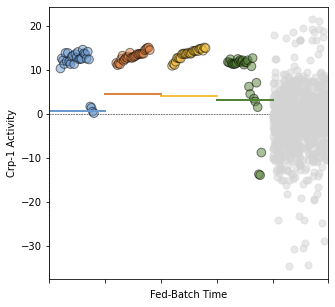

In [56]:
_iM = 'Crp-1'
_sample_groups = ['WT', 'HMP3071', 'SDT551', 'HMP3427']
_colors = ['#6a99d0', '#df8344', '#f5c242', '#548235']

_data_matrix = precise_ddb_nr_json_data.A.copy()
_metadata = hr_process_samples_metadata.copy()
_process_data = processdata.copy()

_sample_list = _metadata[_metadata['sample_group'].isin(_sample_groups)].index.tolist()
_precise_list = _data_matrix.loc[_iM,_data_matrix.columns.str.contains('ecoli', regex=False)].index.tolist()

_, ax = plt.subplots(figsize=(5, 5))

ax.axvline(0, linestyle='--', color='black', zorder=-1, linewidth=0.5)
ax.axhline(0, linestyle='--', color='black', zorder=-1, linewidth=0.5)

df_plot = _metadata.loc[_sample_list,['sample_group', 'category', 'treatment']].copy()
df_plot.loc[_sample_list,'fed-batch time [h]'] = _process_data.loc[_sample_list,'fed-batch time [h]']


for _i in range(len(_sample_groups)):
    _idx  = df_plot[df_plot['sample_group'] == _sample_groups[_i]][df_plot['category'] != 'phase_0'].sort_values(by=['sample_group', 'fed-batch time [h]']).index.to_list()
    _batch = df_plot[df_plot['sample_group'] == _sample_groups[_i]][df_plot['category'] == 'phase_0'].sort_values(by=['sample_group', 'fed-batch time [h]']).index.to_list()
    df_plot.loc[_idx+_batch,_iM] = _data_matrix[_idx+_batch].loc[_iM]
    df_plot.loc[_idx+_batch,'color'] = _colors[_i]
    df_plot.loc[_idx,'#'] = np.linspace(_i+0.2, _i+0.8, num=len(_idx))
    ax.plot([_i, _i+1], [statistics.mean(df_plot.loc[_batch,_iM]),statistics.mean(df_plot.loc[_batch,_iM])], c=_colors[_i], marker='None', linestyle='-', linewidth=2)
    ax.scatter(df_plot.loc[_idx,'#'], df_plot.loc[_idx,_iM], marker='o', c=df_plot.loc[_idx,'color'], s=75, alpha=0.5, linewidths=1, edgecolors="k")

ax.scatter(len(_sample_groups)+(np.random.randint(100, size=(len(_precise_list)))/100), _data_matrix[_precise_list].loc[_iM_list[0]], c='lightgray', s=50, alpha=0.5, linewidths=1, edgecolors="lightgray")

ax.set_xlim([-0, len(_sample_groups)+1])
ax.set_xticklabels([])

ax.set_ylabel(f'{_iM} Activity', fontsize=10)
ax.set_xlabel(f'Fed-Batch Time', fontsize=10)